* [1. Importing packages](#1.)


* [2. Outline of project's goals](#2.)


* [3. Data Exploration](#3.)


* [4. Data Preparation](#4.)
    * [4.1. Missing values](#4.1.)
    * [4.2. Feature engeneering](#4.2.)
    * [4.3. Data Encoding](#4.3.)
    * [4.4. Handling Outliers](#4.4.)


* [5. Variable Importance](#5.)
    

* [6. Feature Selection](#6.)
    * [6.1. Chi-squared](#6.1.)
    * [6.2. Pearson](#6.2.)
    * [6.3. Mutual information](#6.3.)
    * [6.4. Recursive feature elimination ](#6.4.)
    * [6.5. Final selection ](#6.5.)
    
    
* [7. Data splitting](#7.)


* [8. SMOTE](#8.)


* [9. Data Normalization](#9.)


* [10. Modelling](#10.)
    * [10.1. Random Forest](#10.1.)
    * [10.2. Deep Learning Neural Network](#10.2.)
    * [10.3. Support Vector Machines](#10.3.)
    * [10.4. Decision Tree](#10.4.)
    * [10.5. Ridge Classifier](#10.5.)
    * [10.6. KNeighbors Classifier](#10.6.)
    
    
* [11. Test](#11.)
    * [11.1. Data Preparation](#11.1.)
    * [11.2. Predictions](#11.2.)



  

<hr>
<a class="anchor" id="1.">
    
# 1. Importing packages
    
</a>

In [1]:
#GENERAL
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import ceil
import warnings
import feature_engine.missing_data_imputers as mdi
import category_encoders as ce
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gspec
from datetime import datetime

#SKLEARN
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.preprocessing as prep
import sklearn.neighbors as neighb

#KERAS 
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras.layers import Dropout

<hr>
<a class="anchor" id="2.">
    
# 2. Outline of project's goals
    
</a>

**Outline of the project's objectives:**
- Data Exploration- see what the data looks like, how it is distributed
- Data Preparation and Feature Engineering- create new variables, fill missing values, clean it a little bit; 
- For missing values https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 **we are going to use the modes, temporarily, as it might not be the best process**
- Data Encoding
- Applying Ridge/ Lasso to find most significant variables to be used
- Split the data into Training and Validation
- Outlier Removal- https://humansofdata.atlan.com/2018/03/when-delete-outliers-dataset/ // https://www.quora.com/Is-it-reasonable-to-exclude-outliers-in-your-training-dataset-for-your-classifier
Here, the consensus seems to be: Outliers might reveal important information on the dataset, so it could be unwise to remove them, unless they are explicitely wrong entries. Do one model with outlier removal and one without removing outliers, see if the performance is better or not. In this case, we are not doing a cluster analysis, so outliers shouldn't be that bad. 

- Data Normalization- apply a Normalization scaler to the data, but **remember to apply the same scaler to the test data**; https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well;
https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data;
https://medium.com/analytics-vidhya/feature-scaling-and-normalisation-in-a-nutshell-5319af86f89b; 
https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data (fit only on train)


Splitting before normalizing is done in order to not have 'test data' information leak into your training information. Because this excel file is already the whole training data, this concern does not need to apply. I just have to, afterwards, apply the scale transform to the 'test data'.

**DO ONE WITH SCALING AND ONE WITHOUT SCALING** 
Process the teacher said: Encoding, (D.reduction), Splitting, Outliers then Normalization. 

- Dimensionality Reduction (Principal Components)


- Modelling- apply different models 


https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

https://outline.com/2wVkJM


- Assessment- check how well the model performs
- Clean the test data to be equal to the training data (same variables)
https://stats.stackexchange.com/questions/388014/training-data-has-more-variables-than-test-data

.....................................................................................................................................


**Data Preparation-** 
- Identify if there are any nulls. 
- Clean redundant or poorly written information:
 Get variable with gender. Figure out what to do with the Nans. Use modes (can you use KNN?)
- Plot the variables in boxplots, see the dispersion of the data
- Check and remove outliers. Also I can use the IQR method, Euclidean and Mahalanobis distances.
- Use Lasso or RFE to see the most important variables to use.
- Do column with type A,B,C

- Turn the non-metric variables into binary ones (one-hot encoding) and reduce dimensionality. 
- Encode different variables with different encodings



## The Problem

The problem here seems that: The government of Newland needs to predict the proportion of newcomers that fit into the category of below average income (paying 15% of taxes) or above average income (paying 30% of taxes), before they even step into the city's territory. The idea would be to find some kind of relationship between certain variables and the income (above or below average), for example employment sector, job role, years and educational level, citizen class, etc... 

<hr>
<a class="anchor" id="3.">
    
# 3. Data Exploration
    
</a>

In [2]:
data= pd.read_excel('Train.xlsx')

In [3]:
data.head()

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [4]:
#Separating the data in metric and non metric features
numeric_features = ["CITIZEN_ID","Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]
categorical_features = data.columns.drop(numeric_features).to_list()

In [5]:
data.shape
#22.400 observations and 14 variables

(22400, 15)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22400 entries, 0 to 22399
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CITIZEN_ID              22400 non-null  int64 
 1   Name                    22400 non-null  object
 2   Birthday                22400 non-null  object
 3   Native Continent        22400 non-null  object
 4   Marital Status          22400 non-null  object
 5   Lives with              22400 non-null  object
 6   Base Area               22400 non-null  object
 7   Education Level         22400 non-null  object
 8   Years of Education      22400 non-null  int64 
 9   Employment Sector       22400 non-null  object
 10  Role                    22400 non-null  object
 11  Working Hours per week  22400 non-null  int64 
 12  Money Received          22400 non-null  int64 
 13  Ticket Price            22400 non-null  int64 
 14  Income                  22400 non-null  int64 
dtypes:

In [7]:
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CITIZEN_ID,22400,NaN,NaN,NaN,23685.5,6466.47,12486,18085.8,23685.5,29285.2,34885
Name,22400,16074,Mr. Simon Campbell,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Birthday,22400,11257,"August 15,2025",9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Native Continent,22400,5,Europe,19111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,22400,7,Married,10219,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Lives with,22400,6,Wife,9012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Base Area,22400,40,Northbury,20074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,22400,16,Professional School,7232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of Education,22400,NaN,NaN,NaN,13.1739,2.51245,2,12,13,15,21
Employment Sector,22400,9,Private Sector - Services,15599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
data.corr(method='spearman')
#Income seems to be the most correlated with Years of Education.

,CITIZEN_ID,Years of Education,Working Hours per week,Money Received,Ticket Price,Income
CITIZEN_ID,1.000000,0.000801,-0.005625,0.005585,-0.004126,-0.001914
Years of Education,0.000801,1.000000,0.159087,0.112379,0.076733,0.322377
Working Hours per week,-0.005625,0.159087,1.000000,0.093163,0.059176,0.258562
Money Received,0.005585,0.112379,0.093163,1.000000,-0.066311,0.274788
Ticket Price,-0.004126,0.076733,0.059176,-0.066311,1.000000,0.145743
Income,-0.001914,0.322377,0.258562,0.274788,0.145743,1.000000


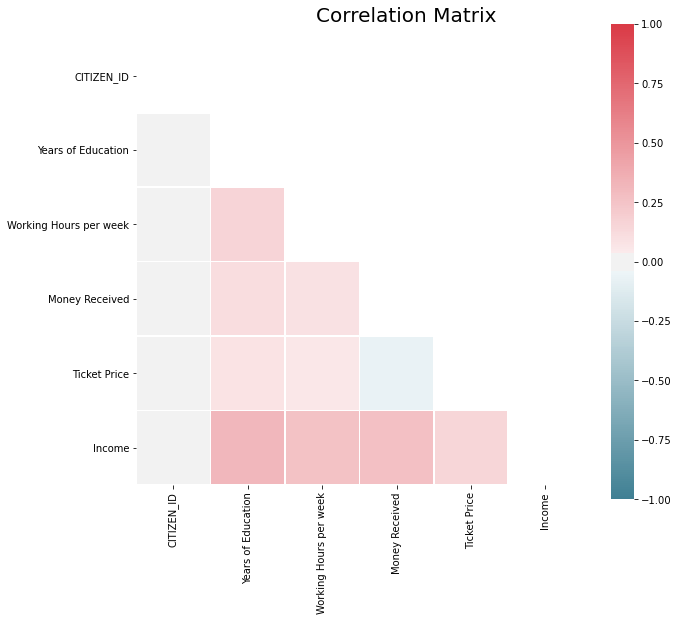

In [9]:
# A way of visualizing the upper table


fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data[numeric_features].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) 

mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr,mask = mask, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

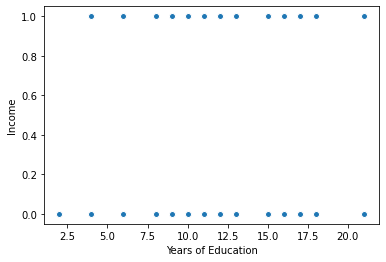

In [10]:
plt.scatter(data["Years of Education"], data["Income"], edgecolors="white")
plt.xlabel("Years of Education")
plt.ylabel("Income")

plt.show()

#Higher years of education tend to concentrate higher income values

In [11]:
data.head(5)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,"July 1,2003",Europe,Married,Wife,Northbury,High School + PostGraduation,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,"January 25,2006",Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
3,12489,Mr. Alexander Gill,"March 25,1985",Europe,Married,Wife,Northbury,High School - 2nd Cycle,11,Private Sector - Services,Security,37,5395,0,1
4,12490,Mr. Neil Piper,"May 29,2015",Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,1


In [12]:
data['Employment Sector'].unique()

array(['Private Sector - Services ', 'Public Sector - Others',
       'Self-Employed (Individual)', 'Private Sector - Others', '?',
       'Self-Employed (Company)', 'Public Sector - Government',
       'Unemployed', 'Never Worked'], dtype=object)

In [13]:
data['Marital Status'].unique()
#consider putting the spouse missing in the married category

array(['Married', 'Single', 'Married - Spouse Missing', 'Divorced',
       'Separated', 'Widow', 'Married - Spouse in the Army'], dtype=object)

In [14]:
data['Lives with'].unique()

array(['Wife', 'Other Family', 'Children', 'Other relatives', 'Alone',
       'Husband'], dtype=object)

In [15]:
data['Base Area'].unique()

array(['Northbury', 'Auchenshuggle', 'Sharnwick', 'Laewaes',
       'MillerVille', '?', 'Fanfoss', 'Wigston', "Knife's Edge",
       'Aerilon', 'Watford', 'Lanercost', 'Bellmoral', 'Marnmouth',
       'Bellenau', 'Butterpond', 'Laenteglos', 'Tranmere', 'Eelry',
       'Alverton', 'Pran', 'Willesden', "King's Watch", 'Kald',
       'Kirkwall', "Fool's March", 'Middlesbrough', 'Orilon',
       'Aroonshire', 'Aberuthven', 'Sharpton', 'Lewes', 'Mensfield',
       'Cherrytown', 'Redwick Bush', 'Drumchapel', 'Carlisle',
       'Conriston', 'Woodpine', 'Ironforge'], dtype=object)

In [16]:
data['Education Level'].unique()

array(['High School + PostGraduation', 'Professional School',
       'High School - 2nd Cycle', 'PhD', 'Bachelors',
       'Bachelors + PostGraduation', 'Masters', 'High School - 1st Cycle',
       'High School Complete', 'Masters + PostGraduation',
       'Professional School + PostGraduation',
       'Middle School - 2nd Cycle', 'Middle School Complete',
       'Middle School - 1st Cycle', 'Primary School', 'Preschool'],
      dtype=object)

In [17]:
#Turning this into an ordinal variable could be:
# 9 - PHD
# 8 - Post Graduation high- bachelors com post, masters com post 
# 7 - Masters
# 6 - Bachelors
# 5 - Post Graduation low - high school com post, professional school com post 
# 4 - High School- high school complete e high school 1st cycle, 2nd cycle
# 3 - Professional School- prof school 
# 2 - Middle School- Middle school complete, 1st cycle, 2nd cycle
# 1 - Primary School
# 0 - Preschool

In [18]:
data['Education Level']= data['Education Level'].str.replace("-","")
data['Education Level']= data['Education Level'].str.replace("+","")
data['Education Level']= data['Education Level'].str.replace("Middle School  1st Cycle","Middle School")
data['Education Level']= data['Education Level'].str.replace("Middle School  2nd Cycle","Middle School")
data['Education Level']= data['Education Level'].str.replace("Middle School Complete","Middle School")
data['Education Level']= data['Education Level'].str.replace("High School  1st Cycle","High School")
data['Education Level']= data['Education Level'].str.replace("High School  2nd Cycle","High School")
data['Education Level']= data['Education Level'].str.replace("High School Complete", "High School")
data['Education Level']= data['Education Level'].str.replace("High School  PostGraduation", "PostGrad Low")
data['Education Level']= data['Education Level'].str.replace("Professional School + PostGraduation","PostGrad Low")
data['Education Level']= data['Education Level'].str.replace("Bachelors  PostGraduation","PostGrad High")
data['Education Level']= data['Education Level'].str.replace("Masters  PostGraduation","PostGrad High")

In [19]:
data['Education Level'].value_counts()

Professional School    7232
PostGrad Low           5947
PostGrad High          4093
High School            1745
Masters                1193
Middle School          1011
Bachelors               735
PhD                     289
Primary School          122
Preschool                33
Name: Education Level, dtype: int64

In [20]:
data['Role'].unique()

array(['Repair & constructions', 'Sales', 'Security', 'Professor',
       'Cleaners & Handlers', 'Other services',
       'Machine Operators & Inspectors', 'Management', 'Administratives',
       'Transports', '?', 'Agriculture and Fishing', 'IT',
       'Household Services', 'Army'], dtype=object)

In [21]:
numeric_features = ["CITIZEN_ID","Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]

In [22]:
#Creating a function to plot Box plot and Histogram
def hist_box_plot(df,feature, fig_num):
    sns.set(color_codes = 'Blue', style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
    filtered = df.loc[~np.isnan(df[feature]), feature]
    sns.boxplot(filtered, ax = ax1, color = 'steelblue') # boxplot
    sns.distplot(filtered, kde=True, hist=True, kde_kws={'linewidth': 1}, color = 'steelblue', ax = ax2) # histogram
    plt.show()

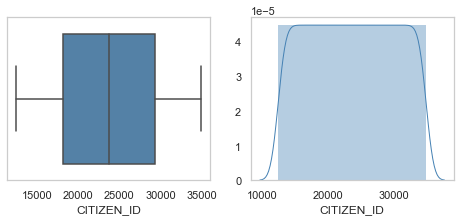

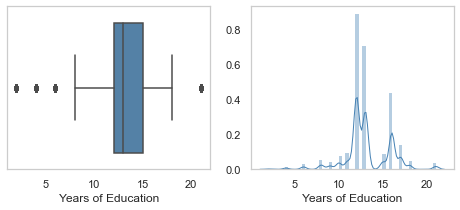

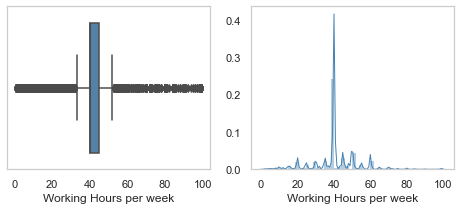

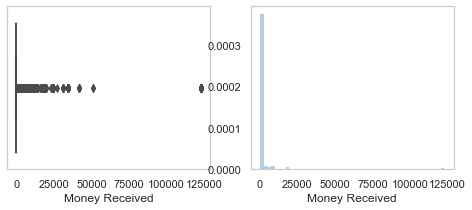

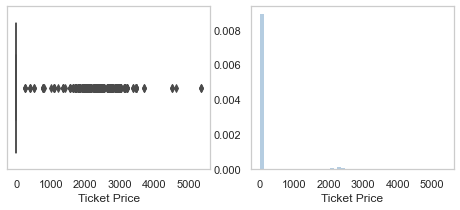

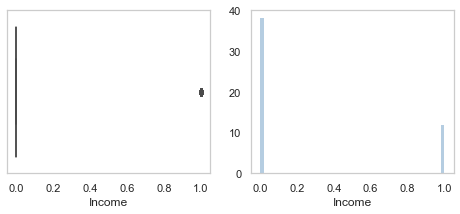

In [23]:
fig_num = 1        
for col in numeric_features:
    hist_box_plot(data,col, fig_num)
    fig_num = fig_num + 1

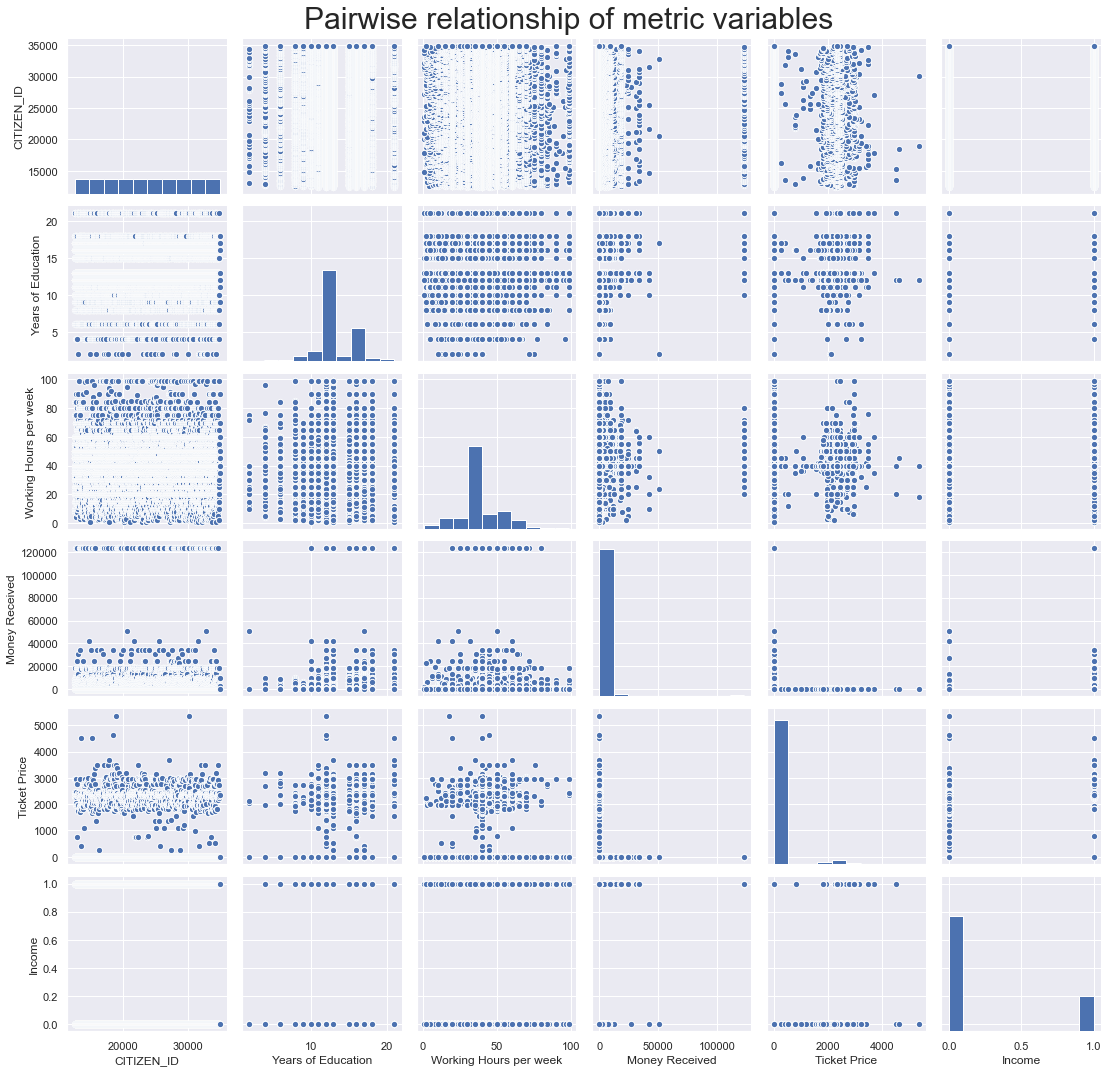

In [24]:
sns.set()

# Setting pairgrid
g = sns.PairGrid(data[numeric_features])

# Populating pairgrid
mdg = g.map_diag(plt.hist, edgecolor="w")
mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)
    
# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of metric variables", fontsize=30)

plt.show()

## .......................................................................................................................................................

<hr>
<a class="anchor" id="4.">
    
# 4. Data Preparation
    
</a>

In [25]:
data.replace("?", np.nan, inplace=True)

In [26]:
#Another proof of that:
data.isna().sum()
#The nulls are all in the non_metric_features

CITIZEN_ID                   0
Name                         0
Birthday                     0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [27]:
data['Birthday']= data['Birthday'].astype(str)
data[data['Birthday']==' May 10,2009']

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
2,12488,Mr. Keith Davidson,"May 10,2009",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1
2792,15278,Mrs. Molly Simpson,"May 10,2009",Europe,Separated,Alone,Northbury,PostGrad Low,13,Private Sector - Services,Other services,75,0,0,0


In [28]:
data['Birthday']= data['Birthday'].str.replace(" ","")

data["Month and Day of Birth"], data['Year of Birth']= data['Birthday'].str.split(",",1).str

data['Age']= 2048- (data['Year of Birth'].astype(int))

data.drop('Birthday', axis=1, inplace=True)

data = data[['CITIZEN_ID','Name','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Income']]

In [29]:
data.head(3)

,CITIZEN_ID,Name,Month and Day of Birth,Year of Birth,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Income
0,12486,Mr. Adam Glover,July1,2003,45,Europe,Married,Wife,Northbury,PostGrad Low,13,Private Sector - Services,Repair & constructions,40,0,2273,1
1,12487,Mr. Cameron McDonald,January25,2006,42,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,1
2,12488,Mr. Keith Davidson,May10,2009,39,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,1


In [30]:
data['Name']= data['Name'].str.replace('Miss','Miss.')
data["title"], data['Name']= data['Name'].str.split(".",1).str

data['title']=data['title'].str.replace("Mr","Male")
data['title']=data['title'].str.replace("Mrs","Female")
data['title']=data['title'].str.replace("Miss","Female")
data['title']=data['title'].str.replace("Males","Male")

data = data[['CITIZEN_ID','Name','title','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Income']]

In [31]:
data.columns=['CITIZEN_ID','Name','Gender','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Income']

In [32]:
numeric_features = ["CITIZEN_ID","Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]
categorical_features = data.columns.drop(numeric_features).to_list()

<hr>
<a class="anchor" id="4.1.">
    
# 4.1. Missing Values
    
</a>

For the missing values we've dealt with them through two different approaches: mode and random sample imputer, and concluded that the second option gives better results, so we followed that one.


In [33]:
missin_va_coluns = data[['Base Area','Employment Sector','Role']]

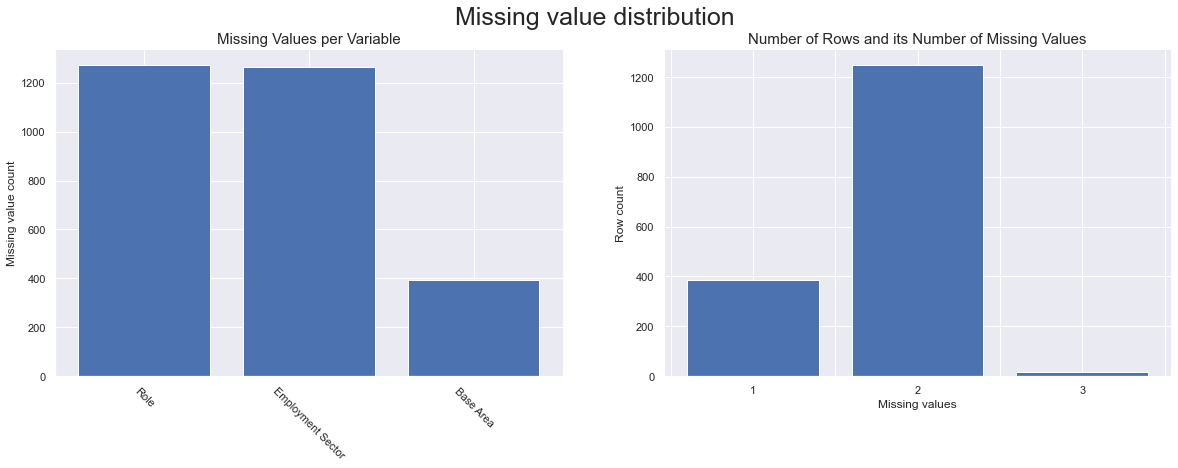

In [34]:
#Number of missing values in each feature
sns.set()

#figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

#data
ax1_data=missin_va_coluns.isna().sum().sort_values(ascending=False)
ax1.bar(x=ax1_data.index, height=ax1_data)
ax2_data=data.isna().apply(lambda x:sum(x), axis=1).value_counts().sort_index().drop(0, axis=0)
ax2.bar(x=ax2_data.index, height=ax2_data)

#layout
plt.suptitle("Missing value distribution", fontsize=25)

ax1.set_ylabel("Missing value count")
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title("Missing Values per Variable", fontsize=15)
for tick in ax1.get_xticklabels():
    tick.set_rotation(-45)

ax2.set_xlabel("Missing values")
ax2.set_ylabel("Row count")
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticklabels(["","",1,"",2,"",3,"",4])
ax2.set_title("Number of Rows and its Number of Missing Values", fontsize=15)

plt.show()

A) MODE 

In [35]:
#modes= data[categorical_features].mode().loc[0]
#modes

In [36]:
#data.fillna(modes,inplace=True)

In [37]:
data.isna().sum()

CITIZEN_ID                   0
Name                         0
Gender                       0
Month and Day of Birth       0
Year of Birth                0
Age                          0
Native Continent             0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

B)IMPUTER

In [38]:
data_to_impute= data.copy()
variables_to_impute= ['Role', 'Base Area', 'Employment Sector']

In [39]:
imputer = mdi.RandomSampleImputer(variables=variables_to_impute,
                          seeding_method='add')
imp_feat= imputer.fit_transform(data_to_impute[variables_to_impute])
imp_df= pd.DataFrame(imp_feat,index=data_to_impute.index, columns= variables_to_impute)
data_to_impute= pd.concat([data_to_impute.drop(columns=variables_to_impute), imp_df], axis=1)

data = data_to_impute.copy()


In [40]:
data.isna().sum()

CITIZEN_ID                0
Name                      0
Gender                    0
Month and Day of Birth    0
Year of Birth             0
Age                       0
Native Continent          0
Marital Status            0
Lives with                0
Education Level           0
Years of Education        0
Working Hours per week    0
Money Received            0
Ticket Price              0
Income                    0
Role                      0
Base Area                 0
Employment Sector         0
dtype: int64

In [41]:
data= data [['CITIZEN_ID', 'Name', 'Gender', 'Month and Day of Birth',
       'Year of Birth', 'Age', 'Native Continent', 'Marital Status',
       'Lives with', 'Education Level', 'Years of Education',
       'Working Hours per week', 'Money Received', 'Ticket Price',
       'Role', 'Base Area', 'Employment Sector', 'Income']]

In [42]:
data.drop(['Month and Day of Birth', 'Name','Year of Birth'], axis= 1, inplace=True)

In [43]:
data['Marital Status']=data['Marital Status'].str.replace(" - Spouse Missing","")
data['Marital Status']=data['Marital Status'].str.replace(" - Spouse in the Army","")
data['Lives with']= data['Lives with'].str.replace("Other relatives","Other Family")

In [44]:
data['Citizen Type'] = 'A'
data.loc[data['Money Received'] > 0,'Citizen Type'] = 'B'
data.loc[data['Ticket Price']> 0, 'Citizen Type']= 'C'

In [45]:
data = data[['CITIZEN_ID','Gender','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Citizen Type','Income']]

In [46]:
data.head(5)

,CITIZEN_ID,Gender,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Citizen Type,Income
0,12486,Male,45,Europe,Married,Wife,Northbury,PostGrad Low,13,Private Sector - Services,Repair & constructions,40,0,2273,C,1
1,12487,Male,42,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,A,1
2,12488,Male,39,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,C,1
3,12489,Male,63,Europe,Married,Wife,Northbury,High School,11,Private Sector - Services,Security,37,5395,0,B,1
4,12490,Male,33,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,A,1


In [47]:
#Updating the categorical and numeric features
numeric_features = ["Age","Years of Education", "Working Hours per week", "Money Received", "Ticket Price", "Income"]
categorical_features = data.columns.drop(numeric_features).to_list()

In [48]:
numeric_features

['Age',
 'Years of Education',
 'Working Hours per week',
 'Money Received',
 'Ticket Price',
 'Income']

In [49]:
categorical_features

['CITIZEN_ID',
 'Gender',
 'Native Continent',
 'Marital Status',
 'Lives with',
 'Base Area',
 'Education Level',
 'Employment Sector',
 'Role',
 'Citizen Type']

<hr>
<a class="anchor" id="4.2.">
    
# 4.2. Feature Engeneering
    
</a>

The variable is a ratio that shows the income per base area, in other words, it indicates the regions that appear to have more people with a positive target.


In [50]:
people_base=data['Base Area'].value_counts() 

income_base=data[data['Income']== 1].groupby('Base Area').count()['Income']
#Keep- Northbury, Alverton, Butterpond, Sharnwick, Watford, Fanfoss, Others

income_base= income_base/ people_base

income_base.fillna(0, inplace=True)

data.set_index('Base Area', inplace=True)
data['Income Base Ratio']= income_base

data.reset_index(inplace=True)

df_=data.copy()
df_.set_index('Base Area', inplace=True)
df_['Income Base Ratio'].drop_duplicates().nlargest(5)

data = data[['CITIZEN_ID','Gender','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Citizen Type','Income Base Ratio','Income']]

<hr>
<a class="anchor" id="4.3.">
    
# 4.3. Data Encoding
    
</a>

In [51]:
data.head(5)

,CITIZEN_ID,Gender,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Citizen Type,Income Base Ratio,Income
0,12486,Male,45,Europe,Married,Wife,Northbury,PostGrad Low,13,Private Sector - Services,Repair & constructions,40,0,2273,C,0.242307,1
1,12487,Male,42,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,A,0.242307,1
2,12488,Male,39,Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Sales,46,0,2321,C,0.242307,1
3,12489,Male,63,Europe,Married,Wife,Northbury,High School,11,Private Sector - Services,Security,37,5395,0,B,0.242307,1
4,12490,Male,33,Europe,Single,Other Family,Northbury,PhD,21,Self-Employed (Individual),Professor,45,0,0,A,0.242307,1


In [52]:
data['Gender'].unique() #OHE

array(['Male', 'Female'], dtype=object)

In [53]:
data['Native Continent'].unique() #OHE

array(['Europe', 'Africa', 'Asia', 'America', 'Oceania'], dtype=object)

In [54]:
data['Marital Status'].unique() #OHE

array(['Married', 'Single', 'Divorced', 'Separated', 'Widow'],
      dtype=object)

In [55]:
data['Base Area'].unique() #OHE

array(['Northbury', 'Auchenshuggle', 'Sharnwick', 'Laewaes',
       'MillerVille', 'Fanfoss', 'Wigston', "Knife's Edge", 'Aerilon',
       'Watford', 'Lanercost', 'Bellmoral', 'Marnmouth', 'Bellenau',
       'Butterpond', 'Laenteglos', 'Tranmere', 'Eelry', 'Alverton',
       'Pran', 'Willesden', "King's Watch", 'Kald', 'Kirkwall',
       'Aroonshire', "Fool's March", 'Middlesbrough', 'Orilon',
       'Aberuthven', 'Sharpton', 'Lewes', 'Mensfield', 'Cherrytown',
       'Redwick Bush', 'Drumchapel', 'Carlisle', 'Conriston', 'Woodpine',
       'Ironforge'], dtype=object)

In [56]:
data['Education Level'].unique() #Label Encoding 

array(['PostGrad Low', 'Professional School', 'High School', 'PhD',
       'Bachelors', 'PostGrad High', 'Masters', 'Middle School',
       'Primary School', 'Preschool'], dtype=object)

In [57]:
data['Employment Sector'].unique() #OHE

array(['Private Sector - Services ', 'Public Sector - Others',
       'Self-Employed (Individual)', 'Private Sector - Others',
       'Self-Employed (Company)', 'Public Sector - Government',
       'Unemployed', 'Never Worked'], dtype=object)

In [58]:
data['Role'].unique() #OHE

array(['Repair & constructions', 'Sales', 'Security', 'Professor',
       'Cleaners & Handlers', 'Other services',
       'Machine Operators & Inspectors', 'Management', 'Administratives',
       'Transports', 'IT', 'Agriculture and Fishing',
       'Household Services', 'Army'], dtype=object)

In [59]:
data['Role'].value_counts()

Professor                         3012
Management                        2963
Repair & constructions            2956
Administratives                   2781
Sales                             2670
Other services                    2421
Machine Operators & Inspectors    1471
Transports                        1154
Cleaners & Handlers                979
Agriculture and Fishing            751
IT                                 657
Security                           474
Household Services                 105
Army                                 6
Name: Role, dtype: int64

In [60]:
df_ohc= data.copy()
df_ohc.head(2)

,CITIZEN_ID,Gender,Age,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price,Citizen Type,Income Base Ratio,Income
0,12486,Male,45,Europe,Married,Wife,Northbury,PostGrad Low,13,Private Sector - Services,Repair & constructions,40,0,2273,C,0.242307,1
1,12487,Male,42,Europe,Married,Wife,Northbury,Professional School,12,Public Sector - Others,Repair & constructions,40,0,0,A,0.242307,1


In [61]:
#Update categorical and numeric features for the encoding:
numeric_features = ["CITIZEN_ID", "Age","Years of Education","Working Hours per week", "Money Received", "Ticket Price", "Income Base Ratio","Income"]
categorical_features = data.columns.drop(numeric_features).to_list()
#categorical_features.remove('Education Level')

In [62]:
one_hot_feat= ["Gender","Native Continent","Marital Status","Lives with","Citizen Type",'Base Area', 'Employment Sector', 'Role']

In [63]:
ohc= OneHotEncoder(sparse= False)
ohc_feat= ohc.fit_transform(df_ohc[one_hot_feat])
ohc_feat_names= ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df

,x0_Female,x0_Male,x1_Africa,x1_America,x1_Asia,x1_Europe,x1_Oceania,x2_Divorced,x2_Married,x2_Separated,...,x7_Household Services,x7_IT,x7_Machine Operators & Inspectors,x7_Management,x7_Other services,x7_Professor,x7_Repair & constructions,x7_Sales,x7_Security,x7_Transports
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22396,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22397,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22398,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [64]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=one_hot_feat), ohc_df], axis=1)
df_ohc.head()

,CITIZEN_ID,Age,Education Level,Years of Education,Working Hours per week,Money Received,Ticket Price,Income Base Ratio,Income,x0_Female,...,x7_Household Services,x7_IT,x7_Machine Operators & Inspectors,x7_Management,x7_Other services,x7_Professor,x7_Repair & constructions,x7_Sales,x7_Security,x7_Transports
0,12486,45,PostGrad Low,13,40,0,2273,0.242307,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,12487,42,Professional School,12,40,0,0,0.242307,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,12488,39,Professional School,12,46,0,2321,0.242307,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,12489,63,High School,11,37,5395,0,0.242307,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,12490,33,PhD,21,45,0,0,0.242307,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


The variable Education Level was turned into an ordinal variable that follows:


 9 - PHD
 
 8 - Post Graduation high- bachelors com post, masters com post 
 
 7 - Masters
 
 6 - Bachelors
 
 5 - Post Graduation low - high school com post, professional school com post 
 
 4 - High School- high school complete e high school 1st cycle, 2nd cycle
 
 3 - Professional School- prof school 
 
 2 - Middle School- Middle school complete, 1st cycle, 2nd cycle
 
 1 - Primary School
 
 0 - Preschool

In [65]:
encoder= ce.OrdinalEncoder(cols= ['Education Level'], return_df= True, 
                      mapping=[{'col':'Education Level',
'mapping':{'Preschool':0,'Primary School':1,'Middle School':2,'Professional School':3,'High School':4,'PostGrad Low':5,'Bachelors':6,'Masters':7,'PostGrad High':8,'PhD':9}}])


In [66]:
encoder_feat= encoder.fit_transform(df_ohc['Education Level'])
encoder_feat_name= encoder.get_feature_names()
enc_df= pd.DataFrame(encoder_feat, index= df_ohc.index, columns= encoder_feat_name)
df_ohc= pd.concat([df_ohc.drop(columns='Education Level'),enc_df], axis=1)

We've tried to encode with two other different perspectives:
- Target Encoder: it gave a lot of overfitting because it will take into account the target variable.
- Leave One Out: worst results than following the perspective adopted.


In [67]:
#
#encoder = ce.target_encoder.TargetEncoder(cols=['Base Area', 'Employment Sector', 'Role'], smoothing=1)
#fit and transform train data 
#df_trans = encoder.fit_transform(X,y)
#check
#df_trans.head()


In [68]:
#loo= ce.leave_one_out.LeaveOneOutEncoder(cols=['Base Area', 'Employment Sector', 'Role'])
#df_ohc= loo.fit_transform(X,y)

In [69]:
data= df_ohc.copy()

In [70]:
data

,CITIZEN_ID,Age,Years of Education,Working Hours per week,Money Received,Ticket Price,Income Base Ratio,Income,x0_Female,x0_Male,...,x7_IT,x7_Machine Operators & Inspectors,x7_Management,x7_Other services,x7_Professor,x7_Repair & constructions,x7_Sales,x7_Security,x7_Transports,Education Level
0,12486,45,13,40,0,2273,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5
1,12487,42,12,40,0,0,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3
2,12488,39,12,46,0,2321,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3
3,12489,63,11,37,5395,0,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4
4,12490,33,21,45,0,0,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22395,34881,25,12,40,0,0,0.242307,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
22396,34882,23,12,35,0,0,0.242307,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3
22397,34883,26,17,40,2674,0,0.242307,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7
22398,34884,37,16,90,0,0,0.242307,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8


In [71]:
#with the 16 most important variables
data_redux= data[['CITIZEN_ID', 'Age','Years of Education','Working Hours per week','Money Received','Ticket Price',
                'x2_Married','x4_A','x6_Private Sector - Others',
       'x6_Private Sector - Services ',
       'x6_Self-Employed (Individual)','x7_Agriculture and Fishing', 'x7_Cleaners & Handlers', 
       'x7_Management','x7_Other services', 'x7_Professor','x7_Machine Operators & Inspectors',
       'x7_Repair & constructions','x3_Alone','Income']]
#Best score so far using these upper variables

<hr>
<a class="anchor" id="4.4.">
    
# 4.4. Handling Outliers
    
</a>

For the outlier removal process we'll try 2 different methods:

- Local Outlier Factor (LOF) - Multivariate Outliers
- Manual Removal of outliers (through visualizations) - Univariate Outliers

We'll first use the LOF to spot and remove multivariate outliers. LOF is based on a concept of a local density, where locality is given by k nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.

In [72]:
initial_num_rows = data.shape[0]

In [73]:
# Since we will use the original data and it isn't standardized
std_data = prep.StandardScaler().fit_transform(data[numeric_features])
lof = neighb.LocalOutlierFactor(n_neighbors=50, contamination="auto")
outlof = lof.fit_predict(std_data)
lof_scores = lof.fit(std_data).negative_outlier_factor_

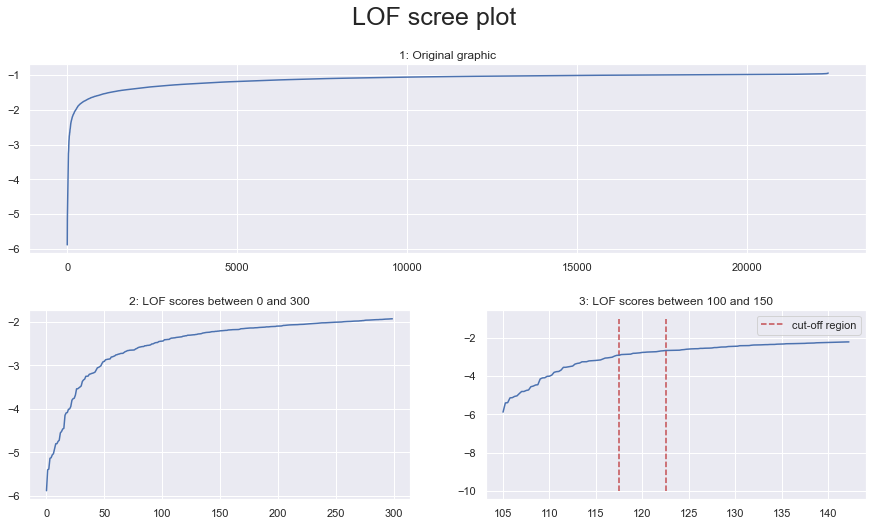

In [74]:
sns.set()
#figure
fig = plt.figure(figsize=(15,8))
fig.suptitle("LOF scree plot", fontsize=25)

#axes
gs = gspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,:]) # First row, first column
ax2 = fig.add_subplot(gs[1,0]) # First row, second column
ax3 = fig.add_subplot(gs[1,1]) # First row, all columns

#data
ax1.plot(np.sort(lof_scores))
ax2.plot(np.sort(lof_scores)[:300])
ax3.plot(np.sort(lof_scores)[0:150], data= np.arange(100, 150, 5))

#layout
ax1.set_title("1: Original graphic")
ax2.set_title("2: LOF scores between 0 and 300")
ax3.set_title("3: LOF scores between 100 and 150")
ax3.set_xticklabels(list(map(str,range(100,150,5)))) #adjust ax3 x axis tick labels
ax3.vlines(x=[50,70], ymin=-10, ymax=-1, color="r", linestyles ="dashed", label="cut-off region")
ax3.legend()
plt.subplots_adjust(hspace=0.3)

plt.show()

From the visualization above, it is possible to notice that the LOF score, which gives a measure of the deviation of density of an observation with respect to its neighbors, is normal for the majority of the observations, however there's a group of around 120 observations whose scores is quite different from the rest. 

Therefore we defined a threshold around the 120th observation with the lowest score so that the ones with lower score will be considered as potential outliers.

In [75]:
top_lof_scores = data.index.isin(lof_scores.argsort()[:120]+1)
top_lof_scores.sum()

120

In [76]:
data = data[~top_lof_scores]

Since the local outlier factor only removed 120 outliers, we decided to do a more robust method, using boxplot and histograms to visualize the data, once there isnt that much features.

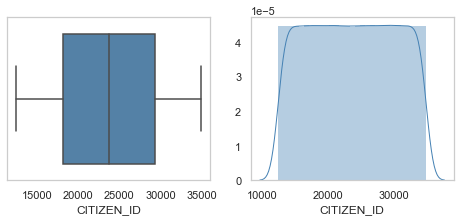

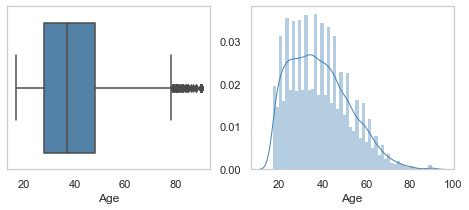

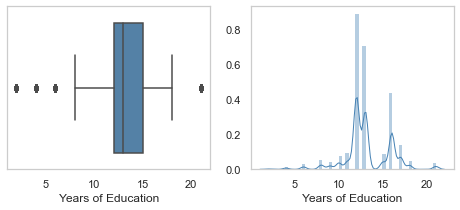

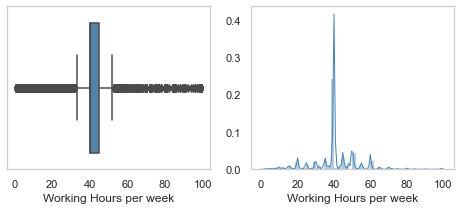

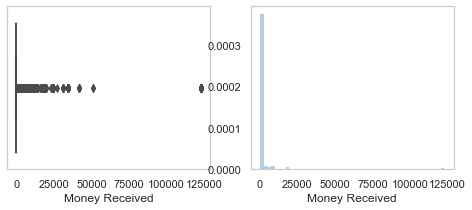

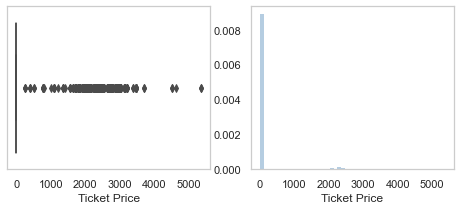

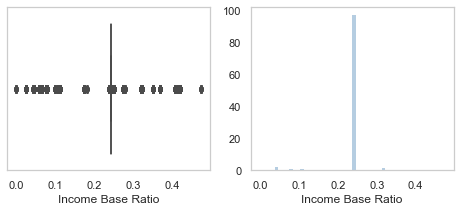

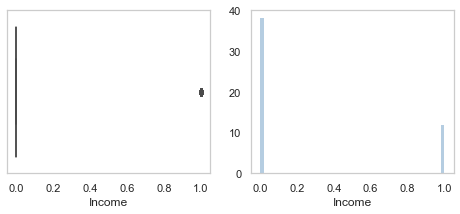

In [77]:
#Creating a function to plot Box plot and Histogram
def hist_box_plot(df,feature, fig_num):
    sns.set(color_codes = 'Blue', style="whitegrid")
    sns.set_style("whitegrid", {'axes.grid' : False})
    sns.set_context(rc = {'patch.linewidth': 0.0})
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
    filtered = df.loc[~np.isnan(df[feature]), feature]
    sns.boxplot(filtered, ax = ax1, color = 'steelblue') # boxplot
    sns.distplot(filtered, kde=True, hist=True, kde_kws={'linewidth': 1}, color = 'steelblue', ax = ax2) # histogram
    plt.show()
    
#This helps identify any possible outliers, visualy, applied only to the numeric variables
fig_num = 1        
for col in numeric_features:
    hist_box_plot(data,col, fig_num)
    fig_num = fig_num + 1

In [78]:
data_original=data.copy()
filters1 = (
    (data['Age']<=89)
    &
    (data['Years of Education']>=3)
    &
    (data['Working Hours per week']<=80)
    &
    (data['Working Hours per week']>=10)
)

In [79]:
data_1 = data[filters1]
print('Percentage of data kept after removing outliers:', np.round(data_1.shape[0] / initial_num_rows, 4)*100, '%')

Percentage of data kept after removing outliers: 97.17 %


In [80]:
data= data_1.copy()

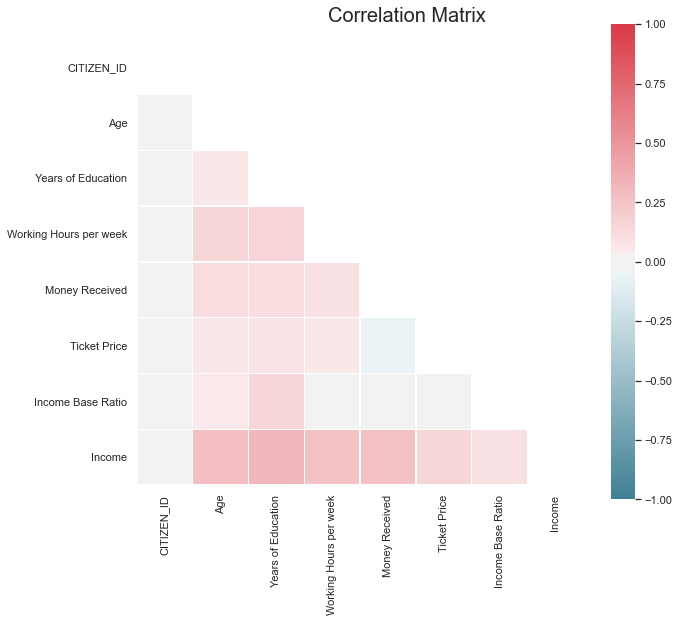

In [81]:


fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data[numeric_features].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # 

mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr,mask = mask, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)


plt.show()

<hr>
<a class="anchor" id="5.">
    
# 5. Variable Importance
    
</a>

In [82]:
data.columns

Index(['CITIZEN_ID', 'Age', 'Years of Education', 'Working Hours per week',
       'Money Received', 'Ticket Price', 'Income Base Ratio', 'Income',
       'x0_Female', 'x0_Male', 'x1_Africa', 'x1_America', 'x1_Asia',
       'x1_Europe', 'x1_Oceania', 'x2_Divorced', 'x2_Married', 'x2_Separated',
       'x2_Single', 'x2_Widow', 'x3_Alone', 'x3_Children', 'x3_Husband',
       'x3_Other Family', 'x3_Wife', 'x4_A', 'x4_B', 'x4_C', 'x5_Aberuthven',
       'x5_Aerilon', 'x5_Alverton', 'x5_Aroonshire', 'x5_Auchenshuggle',
       'x5_Bellenau', 'x5_Bellmoral', 'x5_Butterpond', 'x5_Carlisle',
       'x5_Cherrytown', 'x5_Conriston', 'x5_Drumchapel', 'x5_Eelry',
       'x5_Fanfoss', 'x5_Fool's March', 'x5_Ironforge', 'x5_Kald',
       'x5_King's Watch', 'x5_Kirkwall', 'x5_Knife's Edge', 'x5_Laenteglos',
       'x5_Laewaes', 'x5_Lanercost', 'x5_Lewes', 'x5_Marnmouth',
       'x5_Mensfield', 'x5_Middlesbrough', 'x5_MillerVille', 'x5_Northbury',
       'x5_Orilon', 'x5_Pran', 'x5_Redwick Bush', 'x5_S

In [83]:
data = data [['CITIZEN_ID', 'Age', 'Years of Education', 'Working Hours per week',
       'Money Received', 'Ticket Price', 'Income Base Ratio',
       'x0_Female', 'x0_Male', 'x1_Africa', 'x1_America', 'x1_Asia',
       'x1_Europe', 'x1_Oceania', 'x2_Divorced', 'x2_Married', 'x2_Separated',
       'x2_Single', 'x2_Widow', 'x3_Alone', 'x3_Children', 'x3_Husband',
       'x3_Other Family', 'x3_Wife', 'x4_A', 'x4_B', 'x4_C', 'x5_Aberuthven',
       'x5_Aerilon', 'x5_Alverton', 'x5_Aroonshire', 'x5_Auchenshuggle',
       'x5_Bellenau', 'x5_Bellmoral', 'x5_Butterpond', 'x5_Carlisle',
       'x5_Cherrytown', 'x5_Conriston', 'x5_Drumchapel', 'x5_Eelry',
       'x5_Fanfoss', "x5_Fool's March", 'x5_Ironforge', 'x5_Kald',
       "x5_King's Watch", 'x5_Kirkwall', "x5_Knife's Edge", 'x5_Laenteglos',
       'x5_Laewaes', 'x5_Lanercost', 'x5_Lewes', 'x5_Marnmouth',
       'x5_Mensfield', 'x5_Middlesbrough', 'x5_MillerVille', 'x5_Northbury',
       'x5_Orilon', 'x5_Pran', 'x5_Redwick Bush', 'x5_Sharnwick',
       'x5_Sharpton', 'x5_Tranmere', 'x5_Watford', 'x5_Wigston',
       'x5_Willesden', 'x5_Woodpine', 'x6_Never Worked',
       'x6_Private Sector - Others', 'x6_Private Sector - Services ',
       'x6_Public Sector - Government', 'x6_Public Sector - Others',
       'x6_Self-Employed (Company)', 'x6_Self-Employed (Individual)',
       'x6_Unemployed', 'x7_Administratives', 'x7_Agriculture and Fishing',
       'x7_Army', 'x7_Cleaners & Handlers', 'x7_Household Services', 'x7_IT',
       'x7_Machine Operators & Inspectors', 'x7_Management',
       'x7_Other services', 'x7_Professor', 'x7_Repair & constructions',
       'x7_Sales', 'x7_Security', 'x7_Transports', 'Education Level','Income']]

<hr>
<a class="anchor" id="6.">
    
# 6. Feature Selection
    
</a>

We conducted the feature selection with many different methods and joined them in a table (can be seen in the end of this section). With this, we could see the most important variables for our dataset.
First thing: split the data, we only need to do feature selection with the independent variables.


In [84]:
#new dataset named as X that will include all the independent variables
X = data.drop('Income', axis=1)
#new dataset named as y that will include the dependent variable
y = data[['Income']]

<hr>
<a class="anchor" id="6">
    
# 6. Feature Selection
    
</a>

<hr>
<a class="anchor" id="6.1.">
    
# 6.1. Chi-squared
    
</a>

89 selected features
Feature 0: 83.441721
Feature 1: 6010.564597
Feature 2: 1137.714979
Feature 3: 3536.136956
Feature 4: 68493539.766312
Feature 5: 1211464.703378
Feature 6: 1.735106
Feature 7: 706.969521
Feature 8: 121.711446
Feature 9: 171.228628
Feature 10: 17.332377
Feature 11: 2.125820
Feature 12: 26.057738
Feature 13: 26.112299
Feature 14: 290.079225
Feature 15: 2119.026959
Feature 16: 114.773146
Feature 17: 1439.185539
Feature 18: 75.882108
Feature 19: 372.354499
Feature 20: 942.744117
Feature 21: 331.923210
Feature 22: 686.325291
Feature 23: 2021.961121
Feature 24: 262.067367
Feature 25: 1372.183506
Feature 26: 425.731781
Feature 27: 4.835443
Feature 28: 0.007248
Feature 29: 4.689252
Feature 30: 0.754799
Feature 31: 7.041510
Feature 32: 0.005291
Feature 33: 9.763219
Feature 34: 3.077145
Feature 35: 1.619312
Feature 36: 8.516718
Feature 37: 0.007937
Feature 38: 2.185336
Feature 39: 5.246274
Feature 40: 87.921184
Feature 41: 0.014610
Feature 42: 0.314115
Feature 43: 5.011199
Fea

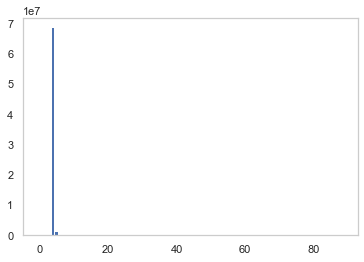

In [85]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
chi_selector = SelectKBest(chi2, k='all')
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

X_fs = chi_selector.transform(X)
#X_val_fs = chi_selector.transform(X_val)

for i in range(len(chi_selector.scores_)):
    print('Feature %d: %f' % (i, chi_selector.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(chi_selector.scores_))], chi_selector.scores_)
plt.show()

In [86]:
chi_selected_features = pd.Series(chi_selector.scores_, index = X.columns)
chi = list(chi_selected_features.sort_values(ascending=False).head(60).index)
chi

['Money Received',
 'Ticket Price',
 'Age',
 'Working Hours per week',
 'x2_Married',
 'x3_Wife',
 'Education Level',
 'x2_Single',
 'x4_B',
 'Years of Education',
 'x3_Children',
 'x7_Management',
 'x0_Female',
 'x3_Other Family',
 'x7_Professor',
 'x7_Other services',
 'x4_C',
 'x3_Alone',
 'x6_Self-Employed (Company)',
 'x3_Husband',
 'x2_Divorced',
 'x4_A',
 'x1_Africa',
 'x7_Cleaners & Handlers',
 'x7_Administratives',
 'x0_Male',
 'x7_Machine Operators & Inspectors',
 'x2_Separated',
 'x5_Fanfoss',
 'CITIZEN_ID',
 'x2_Widow',
 'x6_Public Sector - Government',
 'x6_Private Sector - Services ',
 'x7_Agriculture and Fishing',
 'x1_Oceania',
 'x1_Europe',
 'x7_Household Services',
 'x6_Self-Employed (Individual)',
 'x7_Transports',
 'x1_America',
 'x5_Sharnwick',
 'x6_Public Sector - Others',
 'x7_IT',
 'x5_Pran',
 'x5_Bellmoral',
 'x7_Repair & constructions',
 'x5_Lanercost',
 'x5_Cherrytown',
 'x5_Laewaes',
 "x5_King's Watch",
 'x5_Auchenshuggle',
 "x5_Knife's Edge",
 'x7_Security'

<hr>
<a class="anchor" id="6.2.">
    
# 6.2. Pearson
    
</a>

In [87]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# define feature selection
fs = SelectKBest(score_func=f_regression, k=30)
# apply feature selection
fs.fit(X, y)
fs_support = fs.get_support()
fs_feature = X.loc[:,fs_support].columns.tolist()

X_fs = fs.transform(X)
#X_val_fs = fs.transform(X_val)

fs_selected_features = pd.Series(fs.scores_, index = X.columns)
pearson = list(fs_selected_features.sort_values(ascending=False).head(60).index)
pearson

['x2_Married',
 'x3_Wife',
 'Years of Education',
 'x2_Single',
 'Education Level',
 'x4_A',
 'x4_B',
 'Age',
 'Working Hours per week',
 'x3_Children',
 'Money Received',
 'x3_Other Family',
 'x7_Management',
 'x0_Male',
 'x0_Female',
 'x7_Professor',
 'x7_Other services',
 'Ticket Price',
 'x4_C',
 'x3_Alone',
 'x6_Self-Employed (Company)',
 'x3_Husband',
 'x2_Divorced',
 'x6_Private Sector - Services ',
 'Income Base Ratio',
 'x1_Africa',
 'x7_Administratives',
 'x1_Europe',
 'x7_Cleaners & Handlers',
 'x7_Machine Operators & Inspectors',
 'x2_Separated',
 'x5_Fanfoss',
 'x2_Widow',
 'x6_Public Sector - Government',
 'x7_Agriculture and Fishing',
 'x5_Northbury',
 'x1_Oceania',
 'x7_Household Services',
 'x6_Self-Employed (Individual)',
 'x7_Transports',
 'x1_America',
 'x5_Sharnwick',
 'x6_Public Sector - Others',
 'x7_Repair & constructions',
 'x7_IT',
 'x5_Pran',
 'x5_Bellmoral',
 'x5_Lanercost',
 'x5_Cherrytown',
 'x5_Laewaes',
 "x5_King's Watch",
 'x5_Auchenshuggle',
 "x5_Knife

<hr>
<a class="anchor" id="6.3.">
    
# 6.3. Mutual Information
    
</a>

Feature 0: 0.000000
Feature 1: 0.062981
Feature 2: 0.064388
Feature 3: 0.036408
Feature 4: 0.079201
Feature 5: 0.036613
Feature 6: 0.005852
Feature 7: 0.023498
Feature 8: 0.031928
Feature 9: 0.005166
Feature 10: 0.000192
Feature 11: 0.000979
Feature 12: 0.006312
Feature 13: 0.004170
Feature 14: 0.009877
Feature 15: 0.098595
Feature 16: 0.005887
Feature 17: 0.061666
Feature 18: 0.001113
Feature 19: 0.009953
Feature 20: 0.033359
Feature 21: 0.011891
Feature 22: 0.021208
Feature 23: 0.080419
Feature 24: 0.042556
Feature 25: 0.027820
Feature 26: 0.005408
Feature 27: 0.000014
Feature 28: 0.000000
Feature 29: 0.000000
Feature 30: 0.000000
Feature 31: 0.000003
Feature 32: 0.001636
Feature 33: 0.000000
Feature 34: 0.000000
Feature 35: 0.000000
Feature 36: 0.000000
Feature 37: 0.000000
Feature 38: 0.000451
Feature 39: 0.000914
Feature 40: 0.002373
Feature 41: 0.000000
Feature 42: 0.000000
Feature 43: 0.000000
Feature 44: 0.006620
Feature 45: 0.000000
Feature 46: 0.002530
Feature 47: 0.002782
Fe

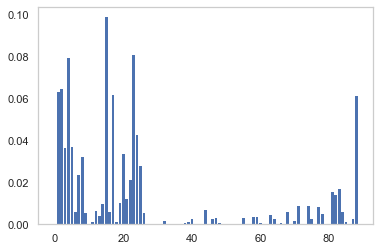

In [88]:
from sklearn.feature_selection import mutual_info_classif
mi_selector = SelectKBest(score_func=mutual_info_classif, k='all')
mi_selector.fit(X, y)
mi_support = mi_selector.get_support()
mi_feature = X.loc[:,mi_support].columns.tolist()
X_fs = mi_selector.transform(X)
#X_val_fs = mi_selector.transform(X_val)

# what are scores for the features
for i in range(len(mi_selector.scores_)):
    print('Feature %d: %f' % (i, mi_selector.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(mi_selector.scores_))], mi_selector.scores_)
plt.show()

In [89]:
mi_selected_features = pd.Series(mi_selector.scores_, index = X.columns)
mi = list(mi_selected_features.sort_values(ascending=False).head(60).index)
mi

['x2_Married',
 'x3_Wife',
 'Money Received',
 'Years of Education',
 'Age',
 'x2_Single',
 'Education Level',
 'x4_A',
 'Ticket Price',
 'Working Hours per week',
 'x3_Children',
 'x0_Male',
 'x4_B',
 'x0_Female',
 'x3_Other Family',
 'x7_Professor',
 'x7_Management',
 'x7_Other services',
 'x3_Husband',
 'x3_Alone',
 'x2_Divorced',
 'x7_Administratives',
 'x6_Self-Employed (Company)',
 'x7_Cleaners & Handlers',
 "x5_King's Watch",
 'x1_Europe',
 'x7_Repair & constructions',
 'x2_Separated',
 'Income Base Ratio',
 'x6_Private Sector - Services ',
 'x4_C',
 'x1_Africa',
 'x7_Household Services',
 'x5_Wigston',
 'x1_Oceania',
 'x5_Redwick Bush',
 'x5_Sharnwick',
 'x5_Northbury',
 'x5_Laenteglos',
 'x7_Agriculture and Fishing',
 'x5_Willesden',
 'x7_Transports',
 "x5_Knife's Edge",
 'x5_Fanfoss',
 'x5_Bellenau',
 'x6_Public Sector - Others',
 'x2_Widow',
 'x7_Sales',
 'x1_Asia',
 'x5_Eelry',
 'x6_Never Worked',
 'x5_Sharpton',
 'x5_Laewaes',
 'x5_Drumchapel',
 'x5_Woodpine',
 'x6_Self-Em

<hr>
<a class="anchor" id="6.4.">
    
# 6.4. Recursive Feature Elimination
    
</a>

In [90]:
rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=15) #, step=10, verbose=5
rfe_selector.fit_transform(X, y)

rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature


['Income Base Ratio',
 'x3_Alone',
 'x3_Children',
 'x3_Husband',
 'x3_Other Family',
 'x3_Wife',
 'x4_A',
 'x4_B',
 'x4_C',
 'x5_Sharpton',
 'x6_Self-Employed (Company)',
 'x6_Unemployed',
 'x7_IT',
 'x7_Management',
 'x7_Professor']

In [91]:
rfe_selector.score(X,y)

0.31607532740496636

In [92]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [93]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_) #lambda, regularization, to avoid overfit
print("Best score using built-in LassoCV: %f" %reg.score(X,y))

Best alpha using built-in LassoCV: 0.873239
Best score using built-in LassoCV: 0.104783


In [94]:
coef = pd.Series(reg.coef_, index = X.columns) 
coef #remove the ones that are 0

CITIZEN_ID                  -1.939230e-07
Age                          2.051289e-03
Years of Education           0.000000e+00
Working Hours per week       5.491765e-04
Money Received               1.010708e-05
                                 ...     
x7_Repair & constructions   -0.000000e+00
x7_Sales                     0.000000e+00
x7_Security                  0.000000e+00
x7_Transports               -0.000000e+00
Education Level              0.000000e+00
Length: 89, dtype: float64

In [95]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables.")


Lasso picked 5 variables and eliminated the other 84 variables.


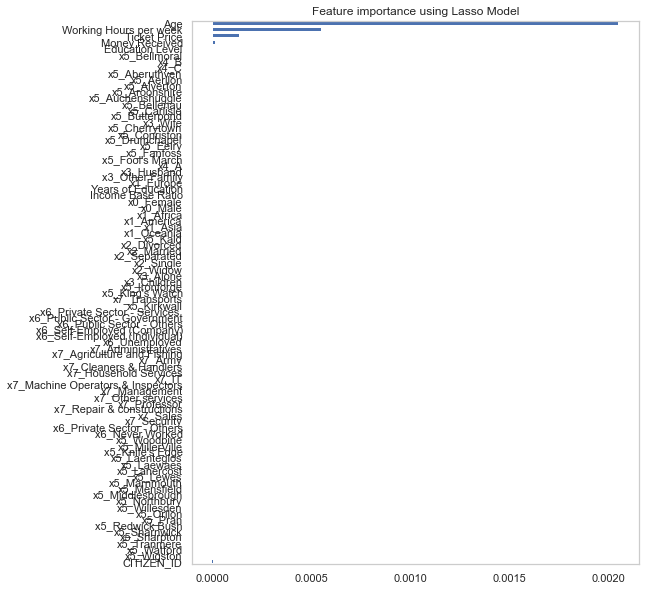

In [96]:
coef.sort_values() 
plot_importance(coef, "Lasso") # most important features are age and working hours per week

In [97]:
lasso = pd.DataFrame(coef)
lasso = abs(lasso[lasso[0] != 0]).sort_values(by=0, ascending=False).head(60).index.tolist()
lasso

['Age',
 'Working Hours per week',
 'Ticket Price',
 'Money Received',
 'CITIZEN_ID']

In [98]:
ridge =RidgeCV()
ridge.fit(X, y)

print("Best alpha using built-in RidgeCV: %f" % ridge.alpha_) 
print("Best score using built-in RidgeCV: %f" %ridge.score(X,y))

Best alpha using built-in RidgeCV: 10.000000
Best score using built-in RidgeCV: 0.374253


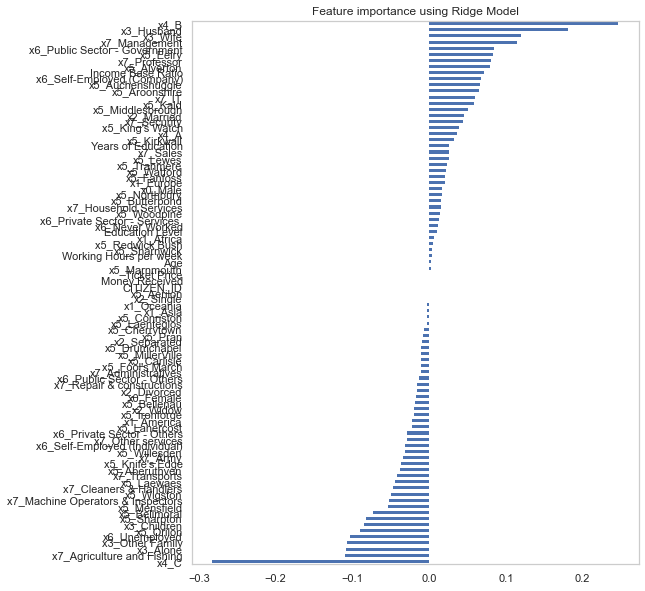

In [99]:
coef_ridge = pd.Series(ridge.coef_[0], index = X.columns) 
plot_importance(coef_ridge, "Ridge")

In [100]:
coef_ridge2 = pd.Series(abs(ridge.coef_[0]), index = X.columns) 
ridge = list(coef_ridge2.sort_values(ascending=False).head(60).index)
ridge

['x4_C',
 'x4_B',
 'x3_Husband',
 'x3_Wife',
 'x7_Management',
 'x7_Agriculture and Fishing',
 'x3_Alone',
 'x3_Other Family',
 'x6_Unemployed',
 'x5_Orilon',
 'x3_Children',
 'x6_Public Sector - Government',
 'x5_Eelry',
 'x5_Sharpton',
 'x7_Professor',
 'x5_Alverton',
 'x5_Bellmoral',
 'Income Base Ratio',
 'x6_Self-Employed (Company)',
 'x5_Auchenshuggle',
 'x5_Aroonshire',
 'x7_IT',
 'x5_Kald',
 'x5_Mensfield',
 'x7_Machine Operators & Inspectors',
 'x5_Middlesbrough',
 'x5_Wigston',
 'x7_Cleaners & Handlers',
 'x2_Married',
 'x5_Laewaes',
 'x7_Security',
 'x7_Transports',
 "x5_King's Watch",
 'x5_Aberuthven',
 "x5_Knife's Edge",
 'x4_A',
 'x7_Army',
 'x5_Kirkwall',
 'x5_Willesden',
 'x6_Self-Employed (Individual)',
 'x7_Other services',
 'x6_Private Sector - Others',
 'Years of Education',
 'x7_Sales',
 'x5_Lewes',
 'x5_Tranmere',
 'x5_Lanercost',
 'x1_America',
 'x5_Watford',
 'x5_Fanfoss',
 'x1_Europe',
 'x5_Ironforge',
 'x2_Widow',
 'x5_Bellenau',
 'x0_Female',
 'x0_Male',
 'x5

<hr>
<a class="anchor" id="6.5.">
    
# 6.5. Final Selection
    
</a>

In [101]:
feat_select = chi+pearson+mi+rfe_feature+ridge+lasso

from collections import Counter

keys = Counter(feat_select).keys() # equals to list(set(words))
frequency = Counter(feat_select).values() # counts the elements' frequency

feat_select = pd.DataFrame(list(zip(keys, frequency)),
                          columns=['Feature', 'Frequency'])

#we will keep the 20 most important features

In [102]:
feat_40 = feat_select.sort_values(by='Frequency', ascending=False).reset_index(drop=True).head(40)
feat_15 = feat_select.sort_values(by='Frequency', ascending=False).reset_index(drop=True).head(15)

In [103]:
feat_select.sort_values(by='Frequency', ascending=False).reset_index(drop=True).head(60)

,Feature,Frequency
0,x3_Other Family,5
1,x4_C,5
2,x3_Wife,5
3,x4_A,5
4,x4_B,5
5,x3_Husband,5
6,x3_Children,5
7,x7_Management,5
8,x6_Self-Employed (Company),5
9,x3_Alone,5


In [104]:
df_40 = X[feat_40.iloc[:,0].tolist()]
df_40

,x3_Other Family,x4_C,x3_Wife,x4_A,x4_B,x3_Husband,x3_Children,x7_Management,x6_Self-Employed (Company),x3_Alone,...,Working Hours per week,x2_Married,Years of Education,x0_Female,x5_King's Watch,x5_Laewaes,Income Base Ratio,x0_Male,x5_Northbury,x5_Laenteglos
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,1.0,13,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,1.0,12,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46,1.0,12,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,37,1.0,11,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45,0.0,21,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22394,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45,1.0,16,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
22395,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,40,0.0,12,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
22396,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,35,0.0,12,0.0,0.0,0.0,0.242307,1.0,1.0,0.0
22397,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,40,0.0,17,1.0,0.0,0.0,0.242307,0.0,1.0,0.0


In [105]:
df_15 = X[feat_15.iloc[:,0].tolist()]
df_15

,x3_Other Family,x4_C,x3_Wife,x4_A,x4_B,x3_Husband,x3_Children,x7_Management,x6_Self-Employed (Company),x3_Alone,x7_Professor,x5_Aberuthven,x7_Agriculture and Fishing,x5_Eelry,x1_Europe
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22394,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22395,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22396,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22397,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


<hr>
<a class="anchor" id="7.">
    
# 7. Data splitting
    
</a>

In [106]:
numeric_features= ["Age","Years of Education","Working Hours per week", "Money Received", "Ticket Price", "Education Level"]
categorical_features = data.columns.drop(numeric_features).to_list()

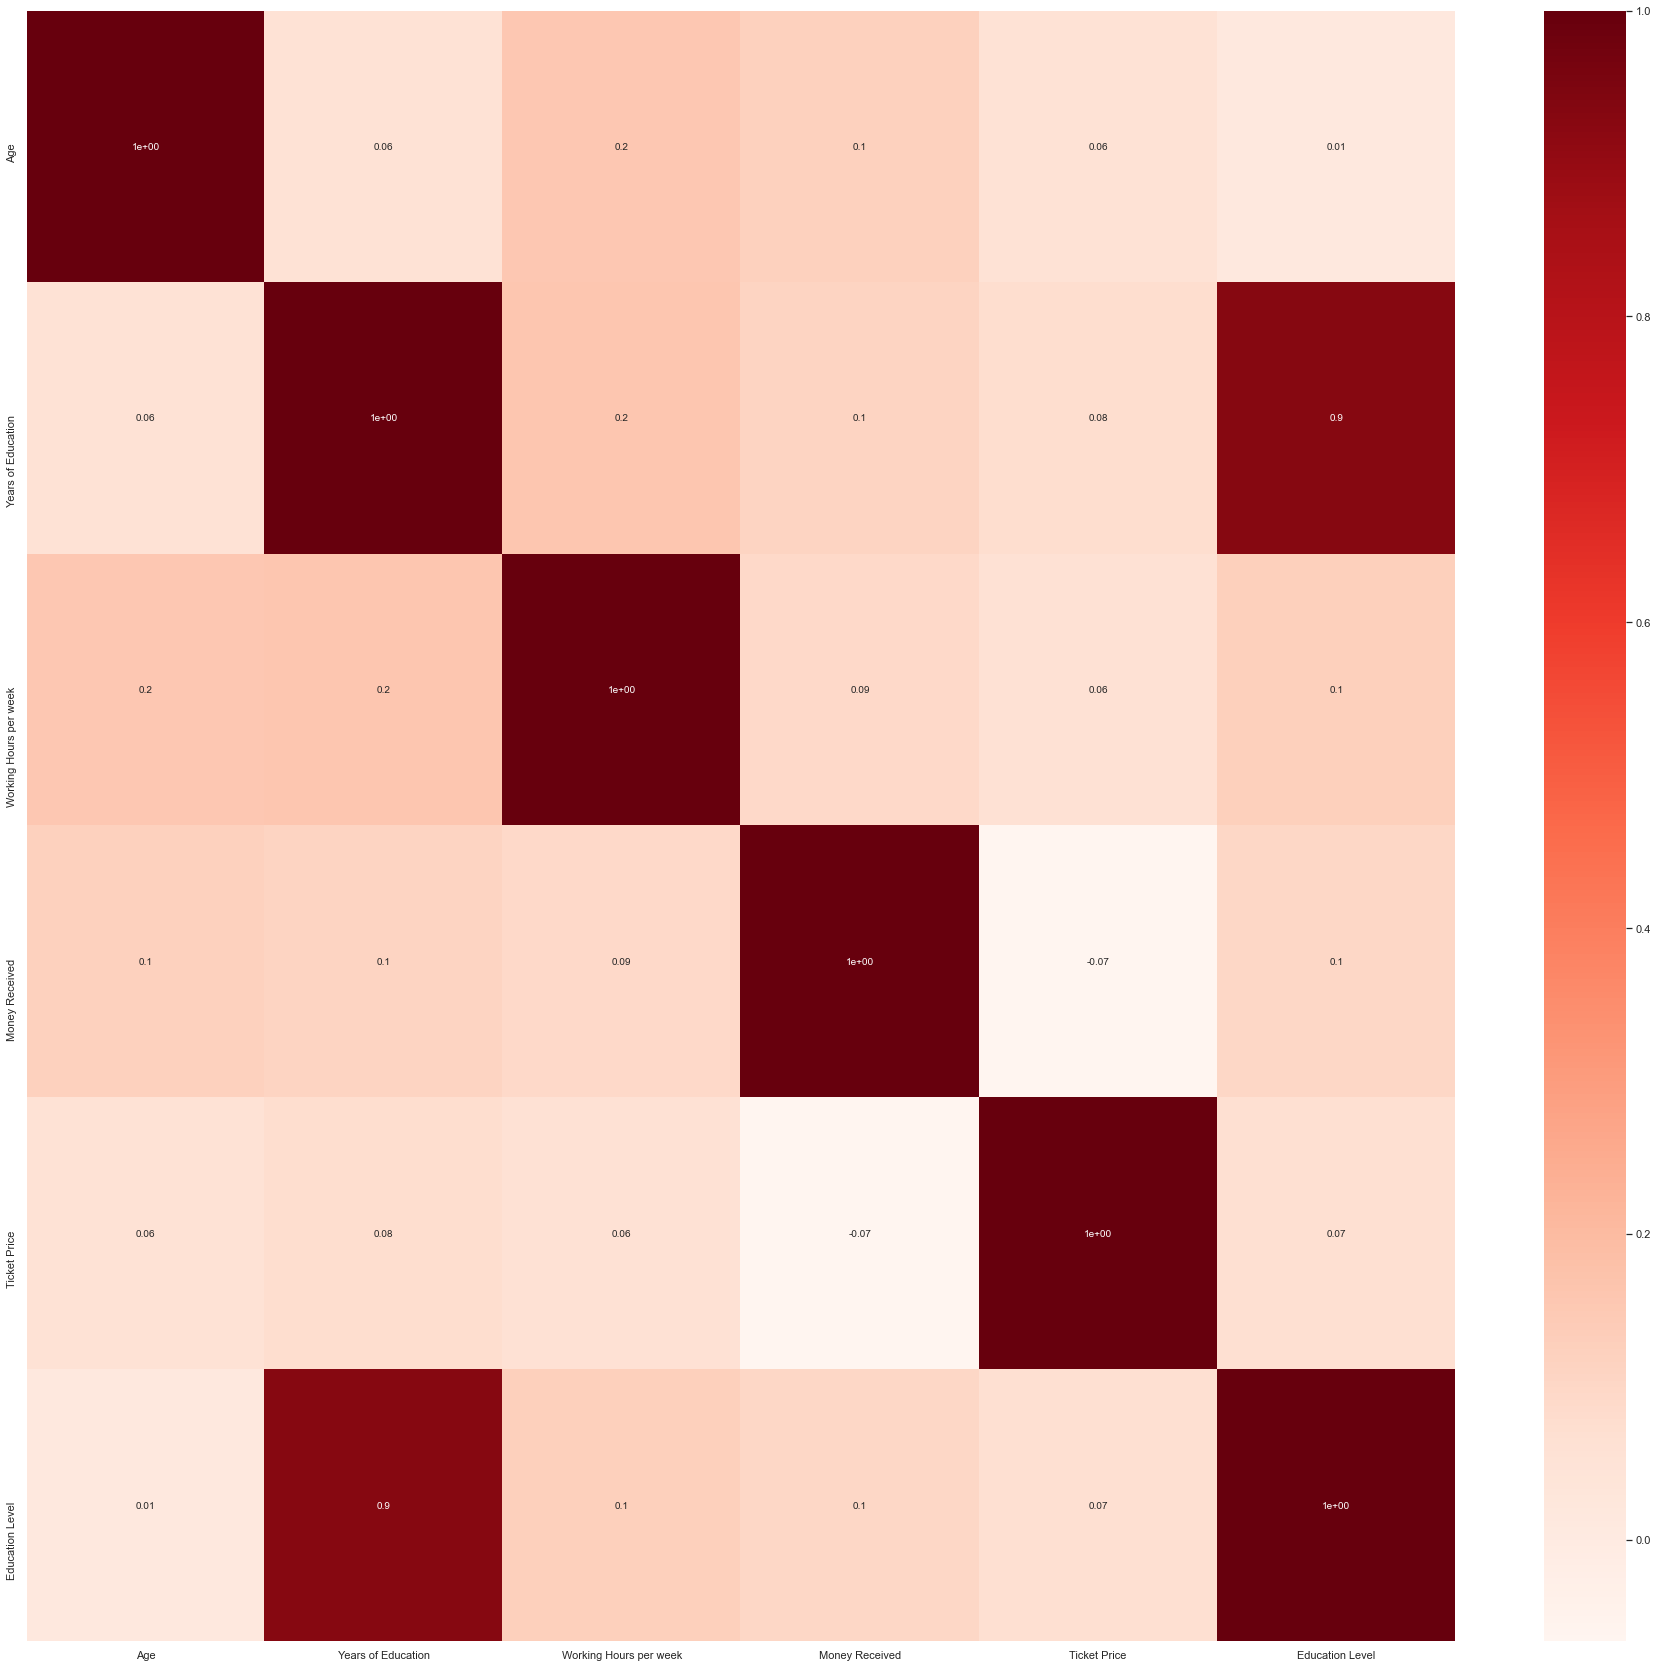

In [107]:
#Using Spearman correlation
%matplotlib inline

def cor_heatmap(cor):
    plt.figure(figsize=(32,30))
    sns.heatmap(data= cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

cor_spearman = data[numeric_features].corr(method ='spearman')
cor_heatmap(cor_spearman)


As can be seen, Education Level is highly correlated with Years of Education, thus Education Level is dropped.
Also, the variable Income Base Ratio has, conceptually, very redundant information, so it will too be removed. 

In [108]:
data.drop('Education Level',axis=1, inplace=True)

In [109]:
data.drop('Income Base Ratio',axis=1, inplace=True)

In [110]:
data.set_index('CITIZEN_ID', inplace=True)

In [111]:
independent= data.iloc[:,:-1]
dependent= data.iloc[:,-1]

In [112]:
data_redux.set_index('CITIZEN_ID', inplace=True)
ind_redux= data_redux.iloc[:,:-1]
dep_redux= data_redux.iloc[:,-1]

In [113]:
X_train, X_val, y_train, y_val = train_test_split(ind_redux,#write here independent for 89 features or df_15 for 15 features
                                                    dep_redux, 
                                                    test_size=0.2, 
                                                    random_state=15, 
                                                    shuffle=True, 
                                                    stratify=dep_redux
                                                   )

In [114]:
y_train.value_counts() #minority class is 31%

0    13671
1     4249
Name: Income, dtype: int64

In [115]:
y_val.value_counts() #minority class is 31%

0    3418
1    1062
Name: Income, dtype: int64

<hr>
<a class="anchor" id="8.">
    
# 8. SMOTE
    
</a>

To try and improve the model score, one attempt tried was to rebalance the minority class of the target variable, given that, out of the whole variable, less than 1/3 corresponds to 1s. For this purpose, SMOTE was used, but not kept in the final model.

In [116]:
#os= SMOTE(random_state=42,sampling_strategy=0.38,k_neighbors=5)
#X_res, y_res= os.fit_resample(X_train, y_train)

<hr>
<a class="anchor" id="9.">
    
# 9. Data Normalization
    
</a>

In [117]:
numeric_features = [ "Age","Years of Education","Working Hours per week", "Money Received", "Ticket Price"]
categorical_features = data.columns.drop(numeric_features).to_list()

In [118]:
#The general rule seems to be: Normalize the data after it is split, but only fit it to the X_train, to the X_test or X_val
#just transform. 

In [119]:
#Updating the numeric features, just for the sake of easing the normalization process. I will not normalize encoded 
#variables, as they are just between 0 and 1, so it does not add much information. From the current list, CITIZEN ID and 
#Income are removed.

#numeric_features.remove('Income Base Ratio')

In [120]:
norm_train= X_train.copy()

In [121]:
scaler = StandardScaler().fit(X_train[numeric_features]) #MinMaxScaler
scaled_train = scaler.transform(X_train[numeric_features])
norm_train[numeric_features]= scaled_train
norm_val= X_val.copy()
scaled_val= scaler.transform(X_val[numeric_features])
norm_val[numeric_features]=scaled_val

**Profile Report**

In [ ]:

ProfileReport(
    data,
    title='Newland',
    correlations={
        "pearson": {"calculate": False},
        "spearman": {"calculate": True},
        "kendall": {"calculate": False},
        "phi_k": {"calculate": False},
        "cramers": {"calculate": False},
    },
)

In [123]:
new_Xtrain = norm_train.copy()
new_ytrain = y_train.copy()
new_X_val = norm_val.copy()
new_y_val = y_val.copy()

<hr>
<a class="anchor" id="10.">
    
# 10. Modelling
    
</a>

 https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5
 
 https://www.bmc.com/blogs/keras-neural-network-classification/
 
 https://www.tensorflow.org/guide/keras/train_and_evaluate
 
 Very interesting explanation https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [125]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))


<hr>
<a class="anchor" id="10.1.">
    
# 10.1. Random Forrest Classifier 
    
</a>

In [126]:
w= 2
regressor = RandomForestClassifier(n_estimators=115, random_state=0,bootstrap='true',
                                   class_weight={0:1, 1:w},max_features='sqrt', max_depth= 24,
                                  min_samples_leaf=4)

regressor.fit(new_Xtrain, y_train)
y_forest_train= regressor.predict(new_Xtrain)
y_forest_val = regressor.predict(new_X_val)

In [127]:
metrics(y_train, y_forest_train, y_val, y_forest_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     13671
           1       0.73      0.81      0.76      4249

    accuracy                           0.88     17920
   macro avg       0.83      0.86      0.84     17920
weighted avg       0.89      0.88      0.88     17920

[[12381  1290]
 [  820  3429]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

In [128]:
scores_train = cross_val_score(regressor, new_Xtrain, y_train, scoring='f1', cv=None, n_jobs=-1)
print ("mean train f1 for Random Forests:",
       "%0.2f (+/- %0.2f)" % (scores_train.mean(), scores_train.std() * 2))

f1= f1_score(y_val, y_forest_val,average='micro')
print(f1)

scores_val = cross_val_score(regressor, new_X_val, y_val, scoring='f1', cv=None, n_jobs=-1)
print ("mean val f1 for Random Forests:",
       "%0.2f (+/- %0.2f)" % (scores_val.mean(), scores_val.std() * 2))

mean train f1 for Random Forests: 0.69 (+/- 0.02)
0.8658482142857142
mean val f1 for Random Forests: 0.69 (+/- 0.03)


In [269]:
# 0.8673254720956094- weighted f1
#0.8214737386708836- macro
# 0.8647220946256317- micro f1

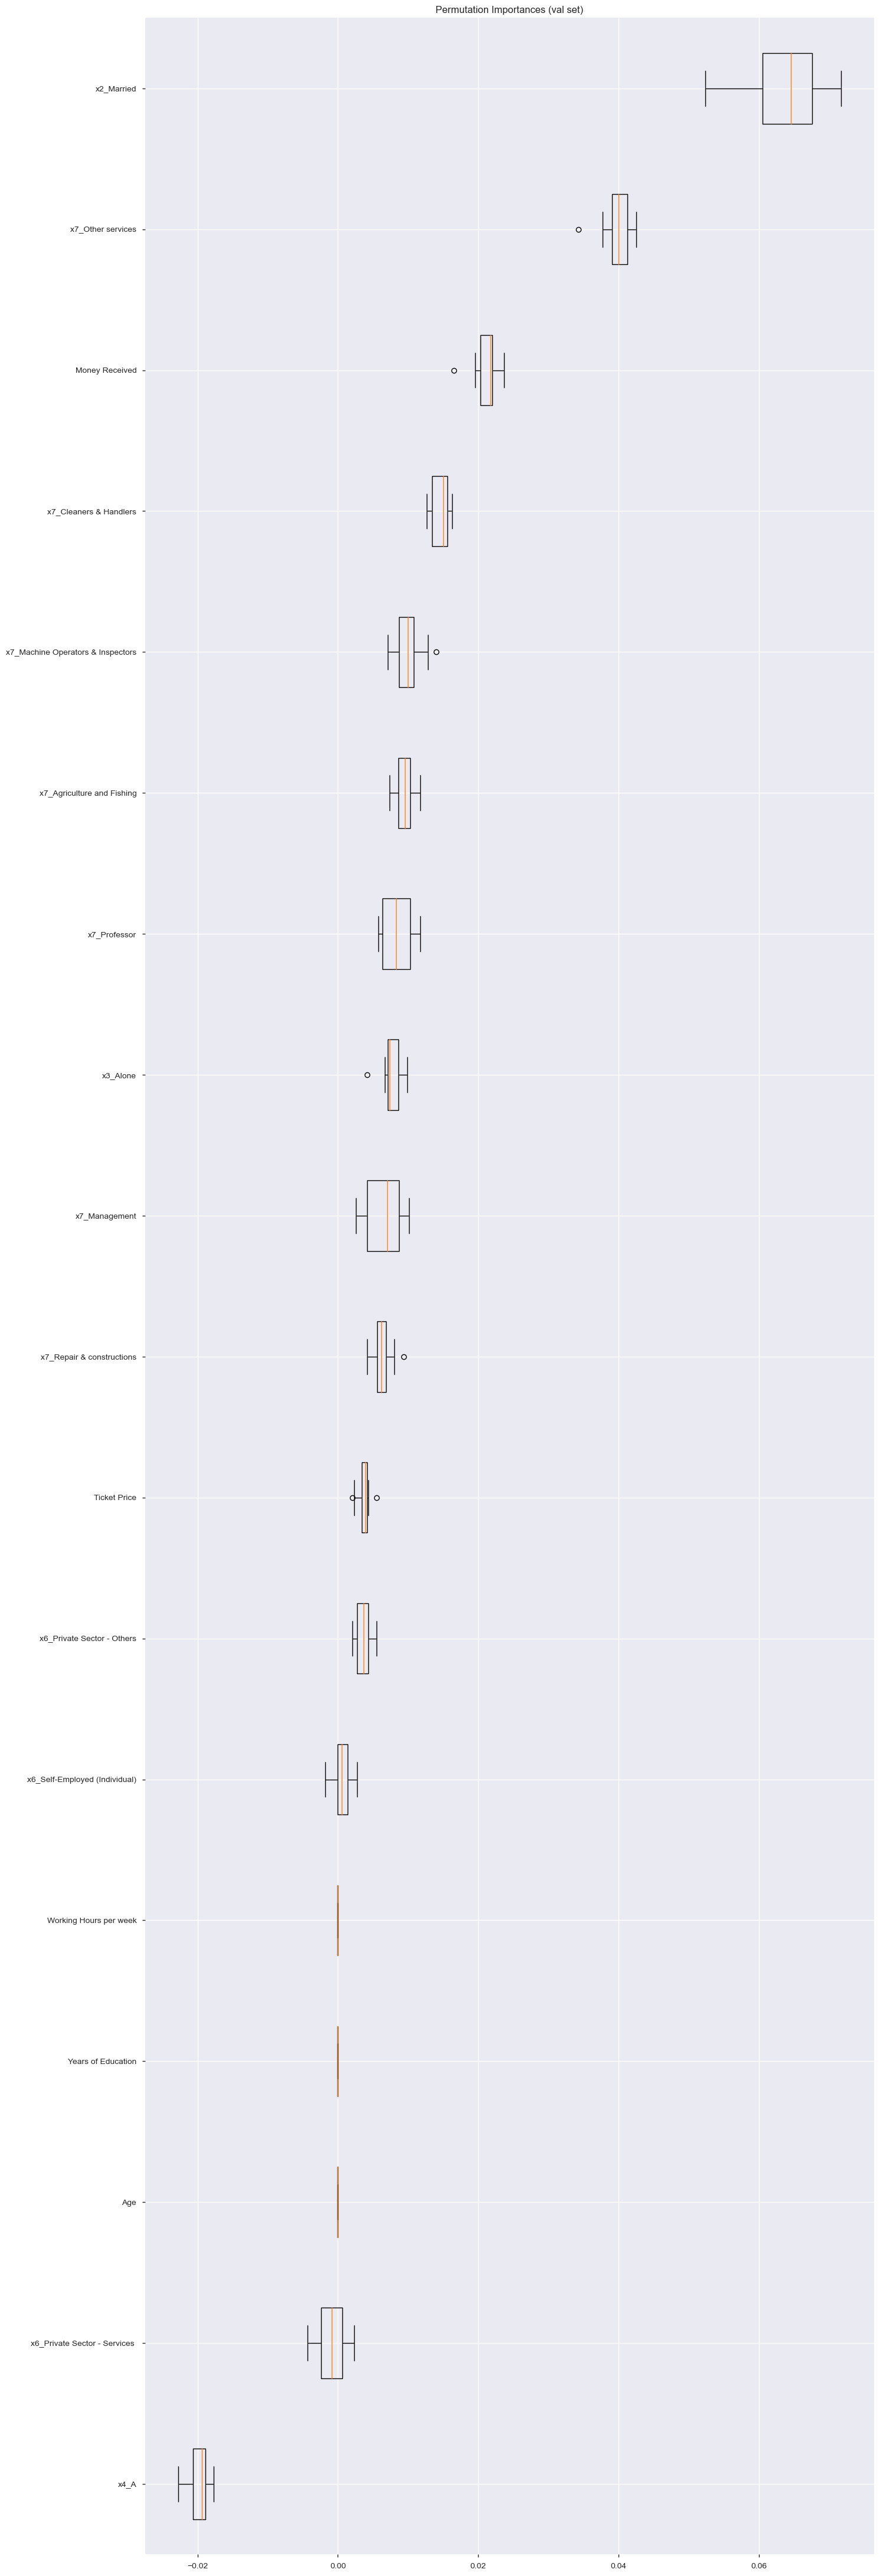

In [270]:
result = permutation_importance(regressor,X_val, y_val, n_repeats=10,
                                random_state=42, n_jobs=2, scoring='f1_micro')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=new_X_val.columns[sorted_idx])
ax.set_title("Permutation Importances (val set)")
fig.tight_layout()

fig.set_size_inches(18.5, 50, forward=True)
plt.show()


In [271]:
scores = ['precision', 'recall']
forest= RandomForestClassifier()
n_estimators = [125]
max_depth = list(range(25,38,2))
min_samples_split = list(range(15,35,2))

min_samples_leaf = [1, 2] 
bootstrap= ['true','false']
class_weight= [{0: w} for w in [1]]



hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,bootstrap=bootstrap, class_weight=class_weight)

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        forest, hyperF, scoring='%s_micro' % score,n_jobs = -1,verbose=2
    )
    clf.fit(new_Xtrain, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(new_Xtest)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Fitting 5 folds for each of 280 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  7.6min finished


Best parameters set found on development set:

{'bootstrap': 'false', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 29, 'n_estimators': 125}

Grid scores on development set:

0.858 (+/-0.009) for {'bootstrap': 'true', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 125}
0.858 (+/-0.010) for {'bootstrap': 'true', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 125}
0.859 (+/-0.011) for {'bootstrap': 'true', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 125}
0.859 (+/-0.008) for {'bootstrap': 'true', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 21, 'n_estimators': 125}
0.859 (+/-0.007) for {'bootstrap': 'true', 'class_weight': {0: 1}, 'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 23, 'n_estimators': 125}
0.858 (+/-0.005) for 

NameError: name 'y_test' is not defined

In [272]:
modelF7 = RandomForestClassifier(max_depth= 25, min_samples_leaf= 1, min_samples_split= 29, n_estimators= 125, bootstrap='false',random_state=40,class_weight= {0: 1})

In [273]:
modelF7.fit(new_Xtrain, y_train)
labels_val = modelF7.predict(new_X_val)
labels_train = modelF7.predict(new_Xtrain)
metrics(y_train, labels_train, y_val, labels_val)
f1= f1_score(y_val,labels_val, average='micro')
print(f1)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     13247
           1       0.84      0.66      0.74      4165

    accuracy                           0.89     17412
   macro avg       0.87      0.81      0.83     17412
weighted avg       0.88      0.89      0.88     17412

[[12718   529]
 [ 1429  2736]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

<hr>
<a class="anchor" id="10.2.">
    
# 10.2. Deep Learning Neural Network
    
</a>

In [285]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [308]:
parameter_space = {
    'hidden_layer_sizes': [(40,30), (50,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': list(np.linspace(0.00001,0.1,5)),
    'learning_rate': ['constant','adaptive'],
    'batch_size':[(100)]
}

In [309]:
model= MLPClassifier()
modelgrid= GridSearchCV(model, parameter_space,scoring='%s_micro' % score,n_jobs = -1,verbose=2)
modelgrid.fit(new_Xtrain,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 45.3min finished


GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'], 'batch_size': [100],
                         'hidden_layer_sizes': [(40, 30), (50, 50), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'learning_rate_init': [1e-05, 0.025007500000000002,
                                                0.05000500000000001, 0.0750025,
                                                0.1],
                         'solver': ['sgd', 'adam']},
             scoring='precision_micro', verbose=2)

In [310]:
modelgrid.best_params_

{'activation': 'relu',
 'batch_size': 100,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.1,
 'solver': 'adam'}

In [311]:
nn= MLPClassifier(hidden_layer_sizes=(100,), activation= 'relu', solver= 'adam',
                  learning_rate_init =0.1,learning_rate= 'constant', batch_size=100)
nn.fit(new_Xtrain,y_train)
y_nn_train= nn.predict(new_Xtrain)
y_nn_val = nn.predict(new_X_val)

In [303]:
metrics(y_train, y_nn_train, y_val, y_nn_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     13247
           1       0.81      0.64      0.72      4165

    accuracy                           0.88     17412
   macro avg       0.85      0.80      0.82     17412
weighted avg       0.87      0.88      0.87     17412

[[12636   611]
 [ 1503  2662]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

# .................................................................................................................................

<hr>
<a class="anchor" id="10.3.">
    
# 10.3. Support Vector Machine
    
</a>

In [294]:
from sklearn import svm

In [300]:
sup = svm.SVC(kernel='rbf', class_weight={0:1, 1:2})
sup.fit(new_Xtrain,y_train)
y_sup_train= sup.predict(new_Xtrain)
y_sup_val = sup.predict(new_X_val)

In [301]:
metrics(y_train, y_sup_train, y_val, y_sup_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     13247
           1       0.62      0.79      0.70      4165

    accuracy                           0.84     17412
   macro avg       0.78      0.82      0.79     17412
weighted avg       0.85      0.84      0.84     17412

[[11273  1974]
 [  887  3278]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------------------------------------------------------------

balanced = BalancedRandomForestClassifier(n_estimators=100, max_depth= 15, class_weight= 'balanced',
                                         random_state=0, )
balanced.fit(new_Xtrain, y_train)
y_balanced_train= balanced.predict(new_Xtrain)
y_balanced_val= balanced.predict(new_X_val)

metrics(y_train, y_balanced_train, y_val, y_balanced_val)

**............................................................................................................................................................** 

easy= EasyEnsembleClassifier(n_estimators=100)
easy.fit(new_Xtrain, y_train)
y_easy_train= balanced.predict(new_Xtrain)
y_easy_val= balanced.predict(new_X_val)

metrics(y_train, y_easy_train, y_val, y_easy_val)

**............................................................................................................................................................** 

clf = RandomForestClassifier()
params = {n_estimators= 'class_weight':[{0:1, 1:neg_weight} for neg_weight in np.arange(1.0, 5.0, 0.5)]}
gs = GridSearchCV(estimator=clf, param_grid=params, cv=5)
gs.fit(new_Xtrain, y_train)

ygs_pred_train= gs.predict(new_Xtrain)
ygs_pred_val= gs.predict(new_X_val)
metrics(y_train, ygs_pred_train, y_val, ygs_pred_val)

**............................................................................................................................................................** 

<hr>
<a class="anchor" id="10.4.">
    
# 10.4. Decision Tree
    
</a>

In [295]:
from sklearn.tree import DecisionTreeClassifier

dt= DecisionTreeClassifier(max_depth=15, min_samples_split=10, min_samples_leaf=10).fit(new_Xtrain, y_train)
y_dt_pred_train= dt.predict(new_Xtrain)
y_dt_pred_val= dt.predict(new_X_val)
metrics(y_train, y_dt_pred_train, y_val, y_dt_pred_val)

<hr>
<a class="anchor" id="10.5.">
    
# 10.5. Ridge Classifier
    
</a>


# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(newX_train, y_train)
grid_result.best_params_
{'alpha': 0.3}
teste123 = RidgeClassifier(alpha= 0.3)
teste123.fit(X_train, y_train)

labels_val = teste123.predict(X_val)
labels_train = teste123.predict(X_train)
metrics(y_train, labels_train, y_val, labels_val)



___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     11962
           1       0.75      0.50      0.60      3717

    accuracy                           0.84     15679
   macro avg       0.80      0.72      0.75     15679
weighted avg       0.83      0.84      0.83     15679

[[11325   637]
 [ 1851  1866]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      5127
           1       0.73      0.53      0.61      1594

    accuracy                           0.84      6721
   macro avg       0.80      0.74      0.76      6721
weighted avg       0.83      0.84      0.83      6721

[[4806  321]
 [ 745  849]]

<hr>
<a class="anchor" id="10.6.">
    
# 10.6.  KNeighborsClassifier
    
</a>


from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']
# define grid search
grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring=f1,error_score=0)
grid_result = grid_search.fit(X_train, y_train)
grid_result.best_params_
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
testea = KNeighborsClassifier(metric= 'manhattan', n_neighbors= 11, weights='uniform')
testea.fit(X_train, y_train)
labels_val = testea.predict(X_val)
labels_train = testea.predict(X_train)
metrics(y_train, labels_train, y_val, labels_val)
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11962
           1       0.78      0.66      0.71      3717

    accuracy                           0.87     15679
   macro avg       0.84      0.80      0.82     15679
weighted avg       0.87      0.87      0.87     15679

[[11272   690]
 [ 1273  2444]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5127
           1       0.74      0.64      0.69      1594

    accuracy                           0.86      6721
   macro avg       0.82      0.78      0.80      6721
weighted avg       0.86      0.86      0.86      6721

[[4777  350]
 [ 578 1016]]
f1= f1_score(y_val,labels_val, average='macro')
print(f1)
0.7989768818618275


<hr>
<a class="anchor" id="11.">
    
# 11. Test
    
</a>

In [274]:
test= pd.read_excel('Test.xlsx',sheet_name='Sheet1')

In [275]:
test.head(4)

,CITIZEN_ID,Name,Birthday,Native Continent,Marital Status,Lives with,Base Area,Education Level,Years of Education,Employment Sector,Role,Working Hours per week,Money Received,Ticket Price
0,34886,Mr. Dan Kerr,"May 13,2012",Europe,Married,Wife,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Sales,40,0,0
1,34887,Miss Olivia Grant,"August 9,2014",Europe,Single,Other Family,Northbury,Bachelors + PostGraduation,16,Private Sector - Services,Professor,36,0,0
2,34888,Mr. Trevor Simpson,"May 23,2020",Europe,Divorced,Other Family,Northbury,Professional School + PostGraduation,13,Private Sector - Services,Management,50,12940,0
3,34889,Mr. David Clark,"April 15,2016",Europe,Married,Wife,Northbury,Professional School,12,Private Sector - Services,Professor,48,0,1827


In [276]:
numeric_features = ["CITIZEN_ID","Years of Education", "Working Hours per week", "Money Received", "Ticket Price"]
categorical_features = test.columns.drop(numeric_features).to_list()
test['Education Level']= test['Education Level'].str.replace("-","")
test['Education Level']= test['Education Level'].str.replace("+","")
test['Education Level']= test['Education Level'].str.replace("Middle School  1st Cycle","Middle School")
test['Education Level']= test['Education Level'].str.replace("Middle School  2nd Cycle","Middle School")
test['Education Level']= test['Education Level'].str.replace("Middle School Complete","Middle School")
test['Education Level']= test['Education Level'].str.replace("High School  1st Cycle","High School")
test['Education Level']= test['Education Level'].str.replace("High School  2nd Cycle","High School")
test['Education Level']= test['Education Level'].str.replace("High School Complete", "High School")
test['Education Level']= test['Education Level'].str.replace("High School  PostGraduation", "PostGrad Low")
test['Education Level']= test['Education Level'].str.replace("Professional School + PostGraduation","PostGrad Low")
test['Education Level']= test['Education Level'].str.replace("Bachelors  PostGraduation","PostGrad High")
test['Education Level']= test['Education Level'].str.replace("Masters  PostGraduation","PostGrad High")
test.replace("?", np.nan, inplace=True)
test['Birthday']= test['Birthday'].astype(str)
test[test['Birthday']==' May 10,2009']
test['Birthday']= test['Birthday'].str.replace(" ","")
test["Month and Day of Birth"], test['Year of Birth']= test['Birthday'].str.split(",",1).str
test['Age']= 2048- (test['Year of Birth'].astype(int))
test.drop('Birthday', axis=1, inplace=True)
test = test[['CITIZEN_ID','Name','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price']]
test['Name']= test['Name'].str.replace('Miss','Miss.')
test["title"], test['Name']= test['Name'].str.split(".",1).str
test['title']=test['title'].str.replace("Mr","Male")
test['title']=test['title'].str.replace("Mrs","Female")
test['title']=test['title'].str.replace("Miss","Female")
test['title']=test['title'].str.replace("Males","Male")
test = test[['CITIZEN_ID','Name','title','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price']]
test.columns=['CITIZEN_ID','Name','Gender','Month and Day of Birth','Year of Birth','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price']
numeric_features = ["CITIZEN_ID","Years of Education", "Working Hours per week", "Money Received", "Ticket Price"]
categorical_features = test.columns.drop(numeric_features).to_list()
test_to_impute= test.copy()
variables_to_impute_t= ['Role', 'Base Area', 'Employment Sector']
imp_feat_test= imputer.transform(test_to_impute[variables_to_impute_t])
imp_df_t= pd.DataFrame(imp_feat_test,index=test_to_impute.index, columns= variables_to_impute_t)
test_to_impute= pd.concat([test_to_impute.drop(columns=variables_to_impute_t), imp_df_t], axis=1)
test = test_to_impute.copy()
test.drop(['Month and Day of Birth', 'Name','Year of Birth'], axis= 1, inplace=True)
test['Marital Status']=test['Marital Status'].str.replace(" - Spouse Missing","")
test['Marital Status']=test['Marital Status'].str.replace(" - Spouse in the Army","")
test['Lives with']= test['Lives with'].str.replace("Other relatives","Other Family")
test['Citizen Type'] = 'A'
test.loc[test['Money Received'] > 0,'Citizen Type'] = 'B'
test.loc[test['Ticket Price']> 0, 'Citizen Type']= 'C'
test = test[['CITIZEN_ID','Gender','Age','Native Continent','Marital Status','Lives with','Base Area','Education Level','Years of Education','Employment Sector','Role','Working Hours per week','Money Received','Ticket Price','Citizen Type']]
numeric_features = ["Age","Years of Education", "Working Hours per week", "Money Received", "Ticket Price"]
categorical_features = test.columns.drop(numeric_features).to_list()
test.drop('Education Level',axis=1, inplace=True)
test.set_index('CITIZEN_ID', inplace=True)


<hr>
<a class="anchor" id="11.1.">
    
# 11.1. Data Preparation
    
</a>

In [277]:
#ENCODING
df_test= test.copy()
ohc_t_feat= ohc.transform(df_test[one_hot_feat])
ohc_t= pd.DataFrame(ohc_t_feat, index= df_test.index, columns= ohc_feat_names)
df_test= pd.concat([df_test.drop(columns=one_hot_feat), ohc_t],axis=1)
test= df_test.copy()

In [278]:
test= test[['Age','Years of Education','Working Hours per week','Money Received','Ticket Price',
                'x2_Married','x4_A','x6_Private Sector - Others',
       'x6_Private Sector - Services ',
       'x6_Self-Employed (Individual)','x7_Agriculture and Fishing', 'x7_Cleaners & Handlers', 
       'x7_Management','x7_Other services', 'x7_Professor','x7_Machine Operators & Inspectors',
       'x7_Repair & constructions','x3_Alone']]

In [279]:
#NORMALIZING
numeric_features = ["Age","Years of Education","Working Hours per week", "Money Received", "Ticket Price"]
categorical_features = test.columns.drop(numeric_features).to_list()

norm_test= test.copy()
scaled_test= scaler.transform(test[numeric_features])
norm_test[numeric_features]=scaled_test

test=norm_test.copy()

In [280]:
test.head(5)

,Age,Years of Education,Working Hours per week,Money Received,Ticket Price,x2_Married,x4_A,x6_Private Sector - Others,x6_Private Sector - Services,x6_Self-Employed (Individual),x7_Agriculture and Fishing,x7_Cleaners & Handlers,x7_Management,x7_Other services,x7_Professor,x7_Machine Operators & Inspectors,x7_Repair & constructions,x3_Alone
CITIZEN_ID,,,,,,,,,,,,,,,,,,
34886,-0.176754,1.144538,-0.055880,-0.143679,-0.216210,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34887,-0.326836,1.144538,-0.420357,-0.143679,-0.216210,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34888,-0.777080,-0.077057,0.855315,1.231770,-0.216210,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34889,-0.476917,-0.484255,0.673076,-0.143679,3.474661,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
34890,-0.101713,0.737340,0.399718,-0.143679,-0.216210,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<hr>
<a class="anchor" id="11.2.">
    
# 11.2.  Predictions
    
</a>

In [281]:
predictions= modelF7.predict(test)

In [282]:
predictions

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [283]:
final_df= pd.DataFrame()
final_df['CITIZEN_ID']= test.index
final_df.set_index('CITIZEN_ID',inplace=True)
final_df['Income']= predictions

final_df.to_csv('Submission_finals')

In [284]:
final_df.head(5)

,Income
CITIZEN_ID,
34886,1
34887,0
34888,1
34889,0
34890,1
